In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')


In [19]:
df = pd.read_csv(".././data/analysis/df_clustering_pca.csv", sep=",")

# With PCA features

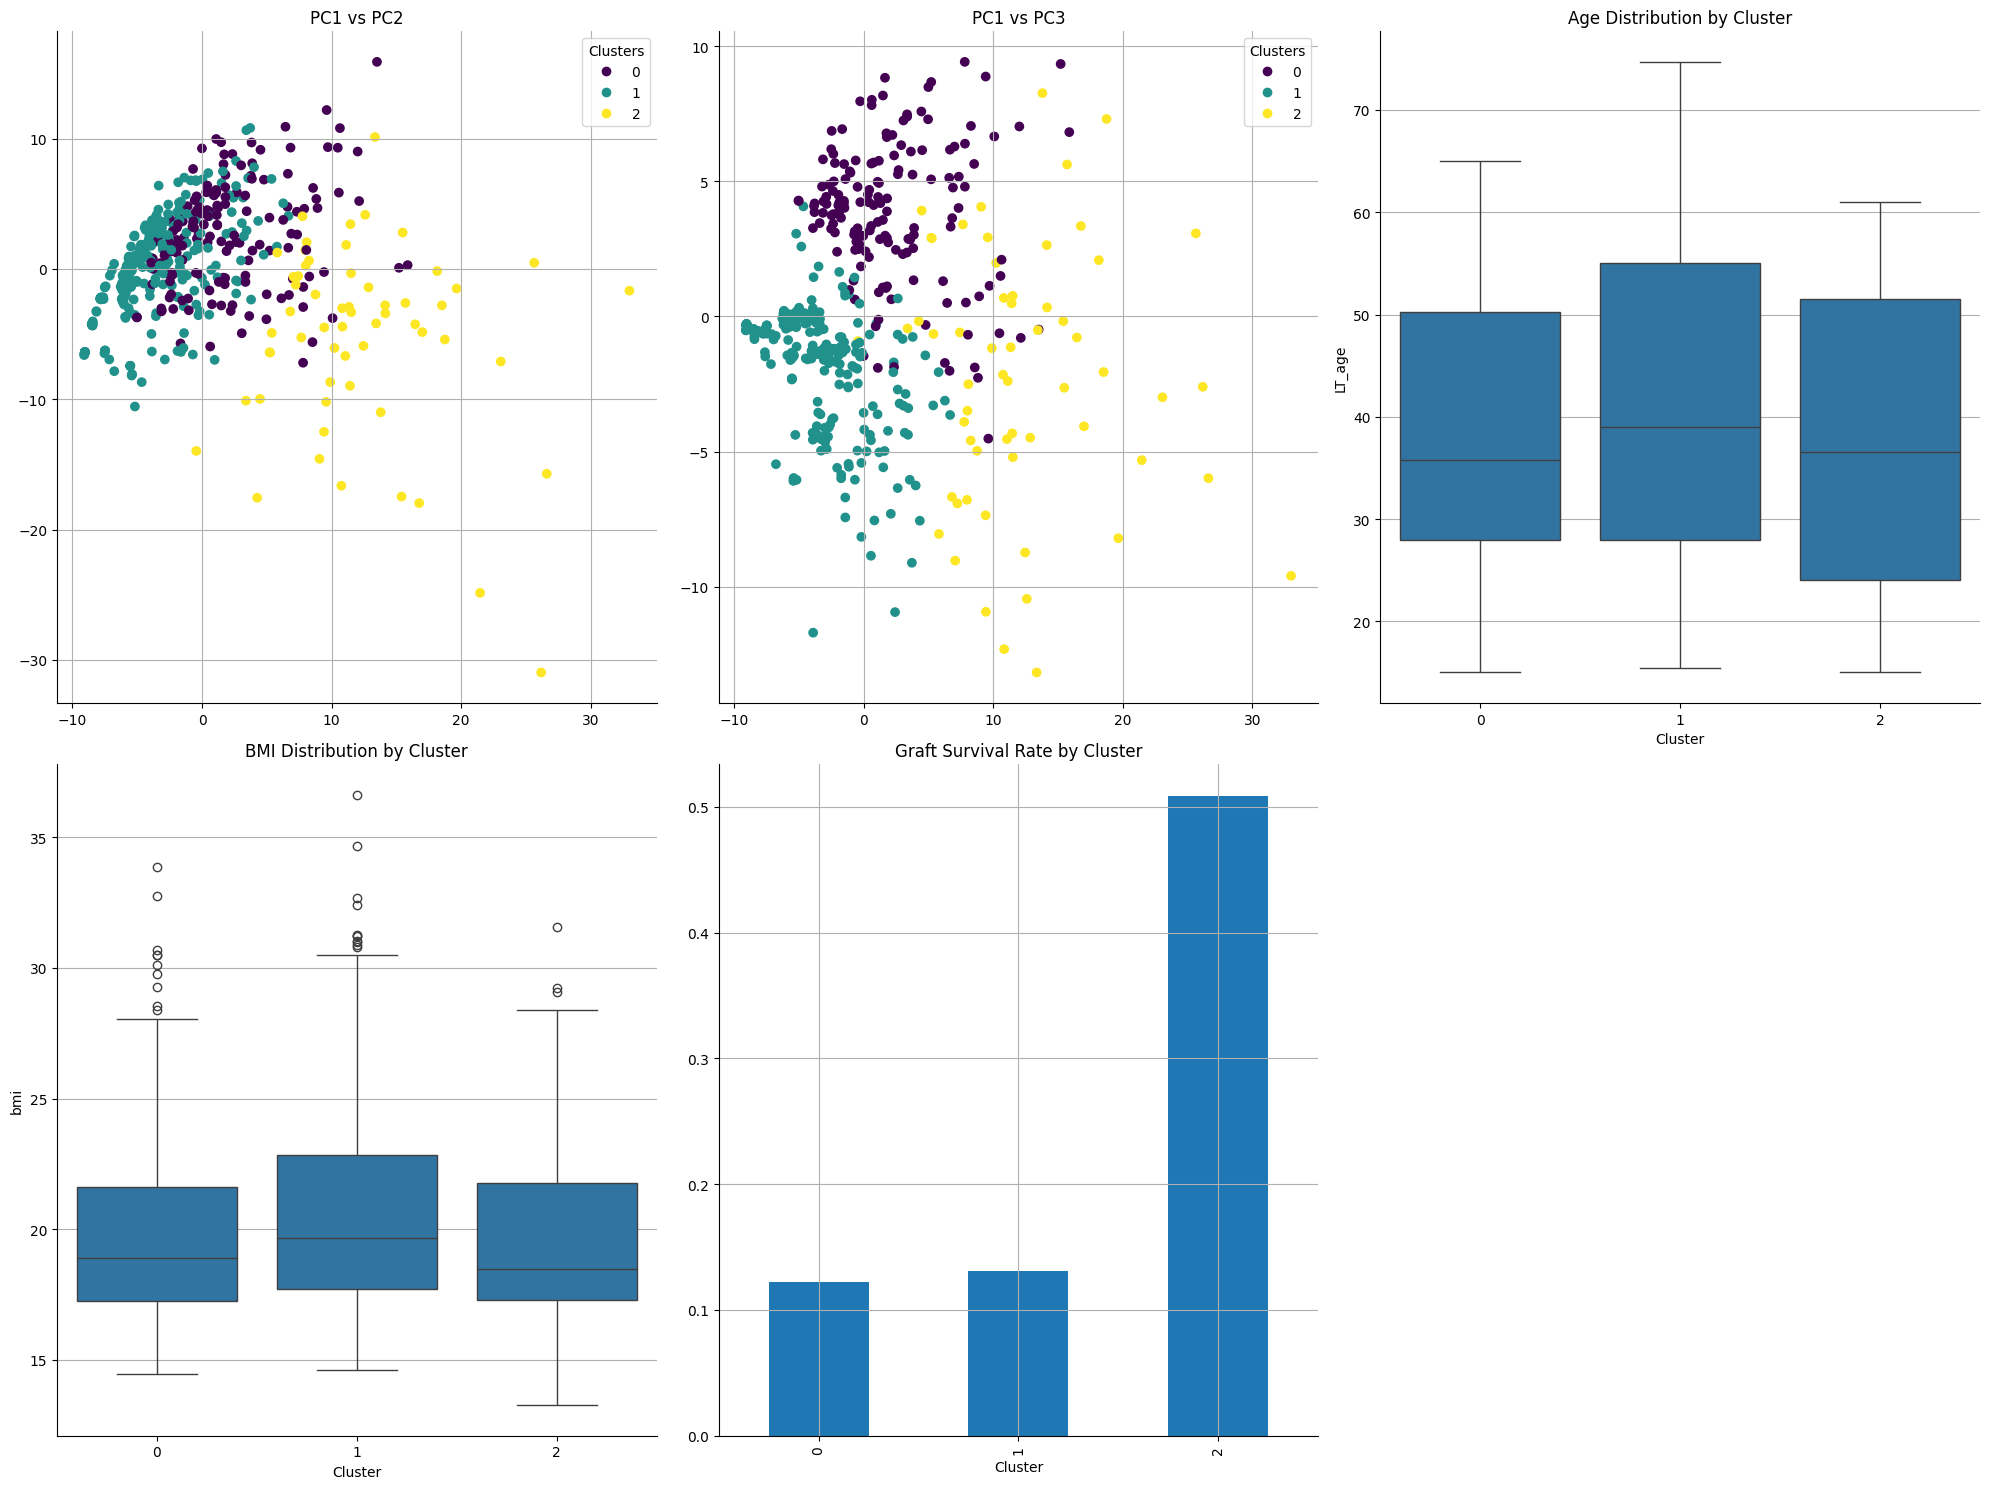

Basic Statistics:
           PC1                      PC2                      PC3        ...  \
          mean   std median count  mean   std median count  mean   std  ...   
Cluster                                                                 ...   
0         2.14  4.33   1.18   156  2.58  4.15   2.53   156  3.85  2.63  ...   
1        -3.73  3.49  -4.03   283 -0.30  3.96  -0.12   283 -1.64  2.29  ...   
2        12.24  6.33  11.12    59 -5.40  7.36  -4.18    59 -2.31  4.85  ...   

                                         PC1_95ci  \
                                                    
Cluster                                             
0        (-4.140319289476128, -3.324151627808503)   
1         (1.4545942400555472, 2.825528681307408)   
2        (10.594861844925443, 13.892360084886914)   

                                          PC2_95ci  \
                                                     
Cluster                                              
0        (-0.7629964927099

In [20]:
class ClusterAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.features = ['PC1', 'PC2', 'PC3']
        self.clinical_features = ['LT_age', 'bmi', 'donneur_age', 'donneur_PF', 'LAS', "ECMO_postop_duree_jours",
                                  "induction"]
        self.categorical_features = ['aetiology', 'gender', 'donneur_tabac', 'SU', 'type_tp', 
                                   'ECMO_postop', 'induction', 'CMV_DR_coded', "re_tx", "DSA_pre",
                                   ]
        
    def prepare_data(self):
        """Prepare and standardize data for clustering"""
        X = self.df[self.features]
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(X)
        return self.X_scaled

    def find_optimal_clusters(self, max_clusters=10):
        """Find optimal number of clusters using multiple metrics"""
        results = {
            'silhouette_scores': [],
            'inertias': []
        }
        
        for k in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(self.X_scaled)
            
            results['silhouette_scores'].append(silhouette_score(self.X_scaled, labels))
            results['inertias'].append(kmeans.inertia_)
            
        return results

    def perform_clustering(self, n_clusters):
        """Perform K-means clustering and add cluster labels"""
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.clusters = self.kmeans.fit_predict(self.X_scaled)
        self.df['Cluster'] = self.clusters
        return self.df

    def analyze_cluster_statistics(self):
        """Perform comprehensive statistical analysis of clusters"""
        try:
            stats_dict = {
                'basic_stats': self._calculate_basic_stats(),
                'clinical_tests': self._perform_clinical_tests(),
                'categorical_tests': self._analyze_categorical_variables(),
                'survival_analysis': self._analyze_survival_patterns(),
                'feature_importance': self._analyze_feature_importance()
            }
            return stats_dict
        except Exception as e:
            print(f"Error in analyze_cluster_statistics: {str(e)}")
            return None

    def _calculate_basic_stats(self):
        """Calculate basic statistics for each cluster"""
        try:
            numeric_cols = self.features + self.clinical_features
            stats_df = self.df.groupby('Cluster')[numeric_cols].agg([
                'mean', 'std', 'median', 'count'
            ]).round(2)
            
            # Calculate confidence intervals
            for col in numeric_cols:
                cluster_cis = []
                for cluster in self.df['Cluster'].unique():
                    cluster_data = self.df[self.df['Cluster'] == cluster][col]
                    ci = stats.t.interval(
                        confidence=0.95,
                        df=len(cluster_data)-1,
                        loc=np.mean(cluster_data),
                        scale=stats.sem(cluster_data)
                    )
                    cluster_cis.append(ci)
                
                stats_df[f'{col}_95ci'] = cluster_cis
            
            return stats_df
        except Exception as e:
            print(f"Error in _calculate_basic_stats: {str(e)}")
            return None

    def _perform_clinical_tests(self):
        """Perform statistical tests on clinical variables"""
        try:
            clinical_tests = {}
            
            for feature in self.clinical_features:
                # Create groups for ANOVA
                groups = [group[feature].values for name, group in self.df.groupby('Cluster')]
                
                # Perform ANOVA
                try:
                    f_stat, p_val = stats.f_oneway(*groups)
                    clinical_tests[feature] = {
                        'test': 'ANOVA',
                        'f_statistic': f_stat,
                        'p_value': p_val
                    }
                except Exception as e:
                    print(f"ANOVA failed for {feature}: {str(e)}")
                    continue
            
            return clinical_tests
        except Exception as e:
            print(f"Error in _perform_clinical_tests: {str(e)}")
            return None

    def _analyze_categorical_variables(self):
        """Analyze categorical variables distribution across clusters"""
        try:
            categorical_analysis = {}
            
            for cat_var in self.categorical_features:
                if cat_var in self.df.columns:  # Check if variable exists
                    contingency = pd.crosstab(self.df['Cluster'], self.df[cat_var])
                    
                    try:
                        chi2, p_val, dof, expected = chi2_contingency(contingency)
                        categorical_analysis[cat_var] = {
                            'contingency_table': contingency,
                            'chi2_statistic': chi2,
                            'p_value': p_val,
                            'dof': dof
                        }
                    except Exception as e:
                        print(f"Chi-square test failed for {cat_var}: {str(e)}")
                        continue
            
            return categorical_analysis
        except Exception as e:
            print(f"Error in _analyze_categorical_variables: {str(e)}")
            return None

    def _analyze_survival_patterns(self):
        """Analyze survival patterns across clusters"""
        try:
            survival_analysis = {}
            
            for cluster in self.df['Cluster'].unique():
                cluster_data = self.df[self.df['Cluster'] == cluster]
                
                survival_analysis[f'Cluster_{cluster}'] = {
                    'graft_survival_rate': (cluster_data['graft_survival_status'] == 0).mean(),
                    'median_survival_time': cluster_data['graft_survival_delay'].median(),
                    'patient_survival_rate': (cluster_data['patient_survival_status'] == 0).mean()
                }
            
            return survival_analysis
        except Exception as e:
            print(f"Error in _analyze_survival_patterns: {str(e)}")
            return None

    def _analyze_feature_importance(self):
        """Analyze feature importance for cluster prediction"""
        try:
            # Combine numerical features
            numerical_features = self.features + self.clinical_features
            X_importance = self.df[numerical_features].copy()
            
            # Handle missing values if any
            X_importance = X_importance.fillna(X_importance.mean())
            
            # Train Random Forest classifier
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X_importance, self.df['Cluster'])
            
            # Get feature importance
            importance_df = pd.DataFrame({
                'feature': X_importance.columns,
                'importance': rf.feature_importances_
            }).sort_values('importance', ascending=False)
            
            return importance_df
        except Exception as e:
            print(f"Error in _analyze_feature_importance: {str(e)}")
            return None

    def visualize_results(self):
        """Create comprehensive visualizations"""
        try:
            fig = plt.figure(figsize=(20, 15))
            
            # PC1 vs PC2
            ax1 = fig.add_subplot(231)
            scatter1 = ax1.scatter(self.df['PC1'], self.df['PC2'], 
                                 c=self.df['Cluster'], cmap='viridis')
            ax1.set_title('PC1 vs PC2')
            ax1.legend(*scatter1.legend_elements(), title="Clusters")
            
            # PC1 vs PC3
            ax2 = fig.add_subplot(232)
            scatter2 = ax2.scatter(self.df['PC1'], self.df['PC3'], 
                                 c=self.df['Cluster'], cmap='viridis')
            ax2.set_title('PC1 vs PC3')
            ax2.legend(*scatter2.legend_elements(), title="Clusters")
            
            # Age distribution
            ax3 = fig.add_subplot(233)
            sns.boxplot(data=self.df, x='Cluster', y='LT_age', ax=ax3)
            ax3.set_title('Age Distribution by Cluster')
            
            # BMI distribution
            ax4 = fig.add_subplot(234)
            sns.boxplot(data=self.df, x='Cluster', y='bmi', ax=ax4)
            ax4.set_title('BMI Distribution by Cluster')
            
            # Survival rate
            ax5 = fig.add_subplot(235)
            survival_rates = self.df.groupby('Cluster')['graft_survival_status'].mean()
            survival_rates.plot(kind='bar', ax=ax5)
            ax5.set_title('Graft Survival Rate by Cluster')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error in visualize_results: {str(e)}")

# Example usage:

analyzer = ClusterAnalyzer(df)
analyzer.prepare_data()
optimal_clusters = analyzer.find_optimal_clusters()
clustered_df = analyzer.perform_clustering(n_clusters=3)
statistics = analyzer.analyze_cluster_statistics()
analyzer.visualize_results()

# Access specific analyses
if statistics:
    print("Basic Statistics:")
    print(statistics['basic_stats'])
    print("\nClinical Tests:")
    print(statistics['clinical_tests'])
    print("\nFeature Importance:")
    print(statistics['feature_importance'].head())


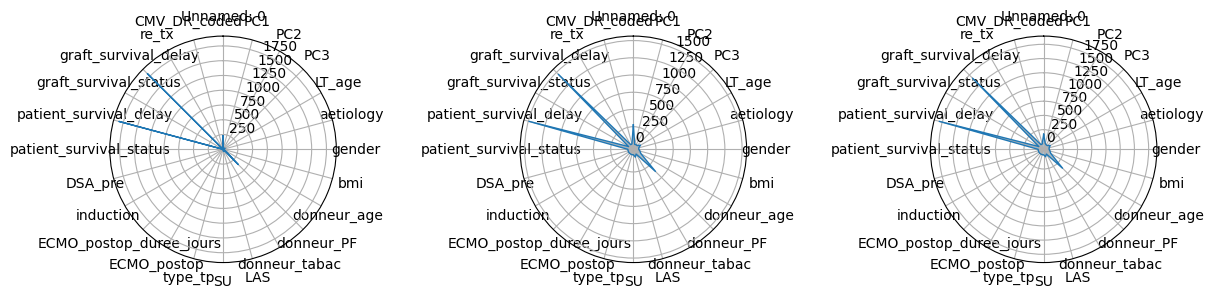

In [21]:
import matplotlib.pyplot as plt
from math import pi

def plot_radar_chart(df, cluster):
    categories = df.columns[:-1]  # Exclude the 'Cluster' column
    values = df.loc[df['Cluster'] == cluster].mean().values[:-1]  # Average values for each feature
    
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = values.tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(3, 3, cluster + 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, alpha=0.4)

plt.figure(figsize=(15, 10))
for cluster in clustered_df['Cluster'].unique():
    plot_radar_chart(clustered_df, cluster)
plt.show()


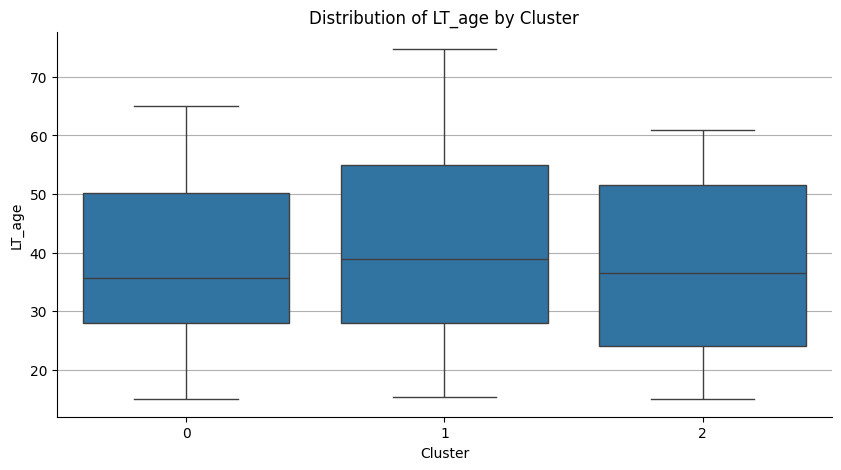

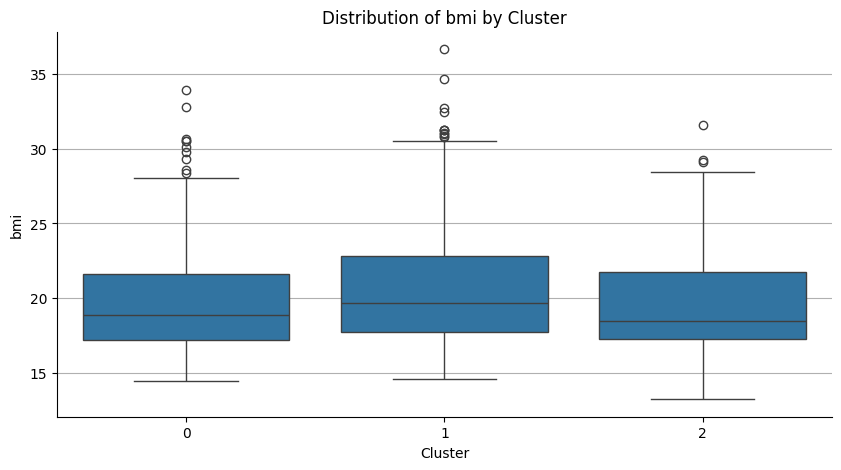

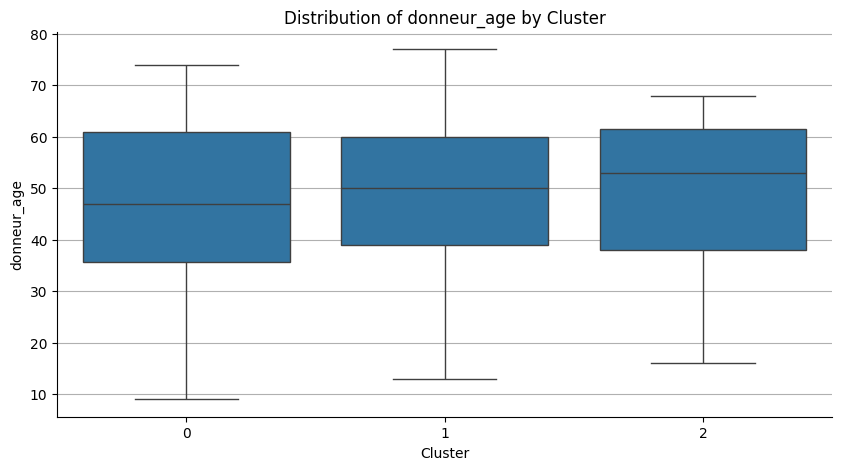

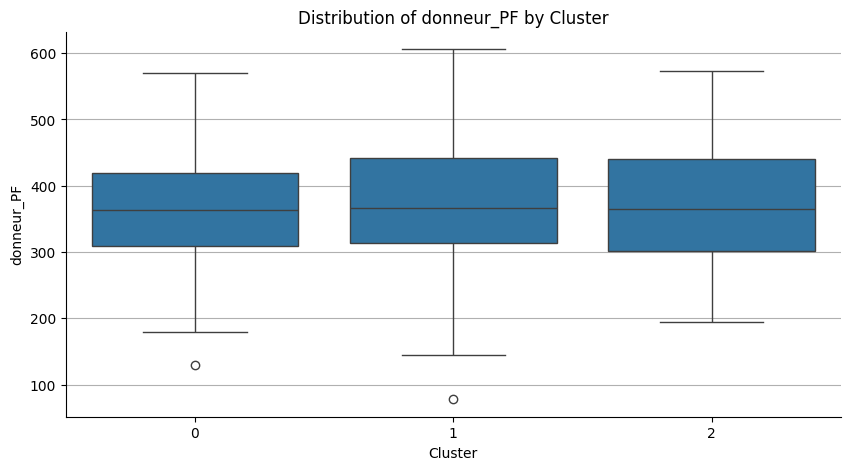

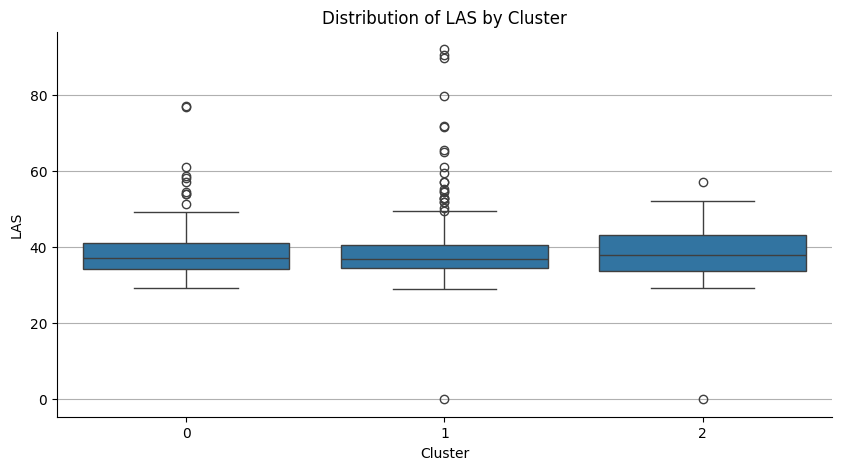

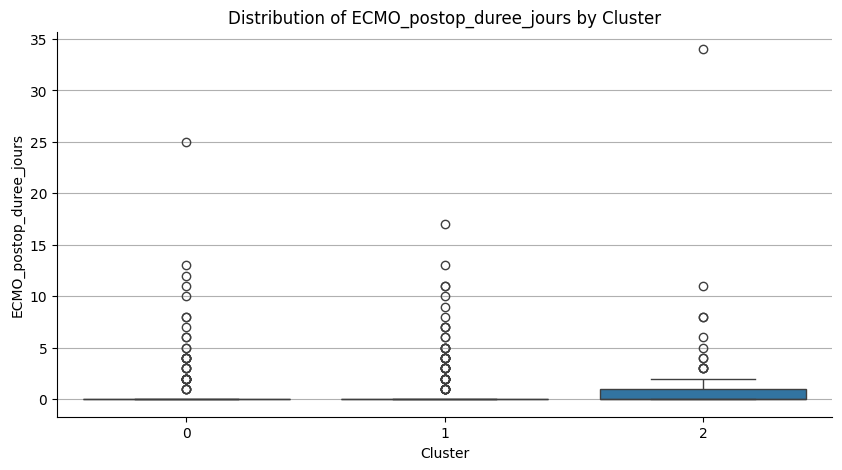

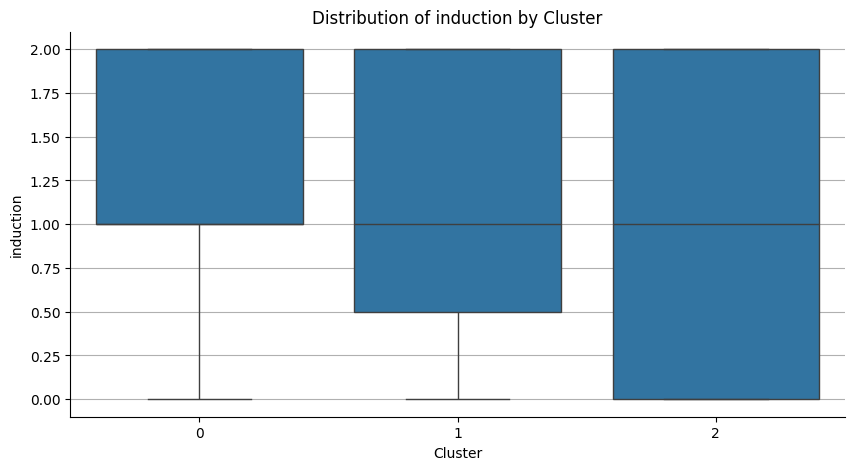

In [22]:
def box_plot_clinical_features(df, feature):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

for feature in analyzer.clinical_features:
    box_plot_clinical_features(clustered_df, feature)


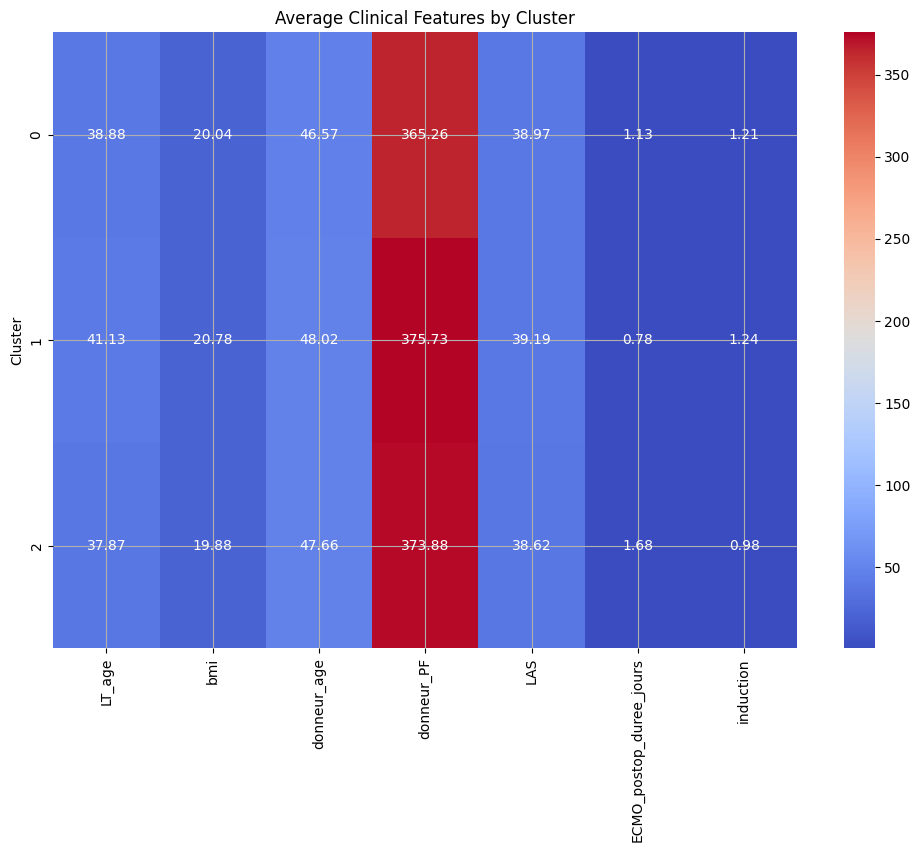

In [23]:
def plot_heatmap(df):
    mean_df = df.groupby('Cluster')[analyzer.clinical_features].mean()
    plt.figure(figsize=(12, 8))
    sns.heatmap(mean_df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Average Clinical Features by Cluster')
    plt.show()

plot_heatmap(clustered_df)


# With raw features

In [24]:
df = pd.read_csv(".././data/analysis/df_clustering_pca.csv", sep=",")

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

class FeatureProcessor:
    def __init__(self, df):
        """Initialize with actual dataframe to check available columns"""
        available_cols = set(df.columns)
        
        # Define potential feature groups and filter for available columns
        potential_numeric_mean = [
            'final_capillarite_agg_mean', 'final_hyperplasie_pn_mean',
            'final_pn_alv_mean', 'final_fibrin_alv_mean', 'final_mPNPorg_mean',
            'final_infiltrat_B_BNSP_mean', 'final_infiltrat_A_A1_A2_mean'
        ]
        
        potential_sequence_metrics = [
            'mean_marqueurs_positifs', 'max_marqueurs_positifs', 'min_marqueurs_positifs',
            'mean_interval_biopsies', 'std_interval_biopsies', 'nb_biopsies',
            'delai_premiere_biopsie', 'delai_derniere_biopsie', 'duree_suivi'
        ]
        
        potential_evolution_features = [
            'stabilite_globale', 'progression_rate', 'nb_clusters_uniques',
            'prop_cluster_dominant', 'nb_changements_cluster'
        ]
        
        potential_clinical_features = [
            'LT_age', 'bmi', 'donneur_age', 'donneur_PF', 'LAS'
        ]
        
        potential_categorical_features = [
            'aetiology', 'gender', 'donneur_tabac', 'SU', 'type_tp',
            'ECMO_postop', 'induction', 'CMV_DR_coded'
        ]
        
        potential_binary_indicators = [
            'final_capillarite_agg_ever_positive', 'final_hyperplasie_pn_ever_positive',
            'final_pn_alv_ever_positive', 'final_fibrin_alv_ever_positive',
            'final_mPNPorg_ever_positive', 'final_infiltrat_B_BNSP_ever_positive',
            'final_infiltrat_A_A1_A2_ever_positive'
        ]
        
        potential_cooccurrence_features = [
            'cooc_capillarite_hyperplasie', 'cooc_capillarite_pn',
            'cooc_capillarite_fibrin', 'cooc_capillarite_mPNPorg',
            'cooc_capillarite_infiltrat', 'cooc_hyperplasie_pn',
            'cooc_hyperplasie_fibrin', 'cooc_hyperplasie_mPNPorg'
        ]
        
        # Filter features based on what's actually available in the dataset
        self.numeric_mean_features = [col for col in potential_numeric_mean if col in available_cols]
        self.sequence_metrics = [col for col in potential_sequence_metrics if col in available_cols]
        self.evolution_features = [col for col in potential_evolution_features if col in available_cols]
        self.clinical_features = [col for col in potential_clinical_features if col in available_cols]
        self.categorical_features = [col for col in potential_categorical_features if col in available_cols]
        self.binary_indicators = [col for col in potential_binary_indicators if col in available_cols]
        self.cooccurrence_features = [col for col in potential_cooccurrence_features if col in available_cols]
        
        # Print available features for verification
        print("Available features:")
        print(f"Numeric mean features: {len(self.numeric_mean_features)}")
        print(f"Sequence metrics: {len(self.sequence_metrics)}")
        print(f"Evolution features: {len(self.evolution_features)}")
        print(f"Clinical features: {len(self.clinical_features)}")
        print(f"Categorical features: {len(self.categorical_features)}")
        print(f"Binary indicators: {len(self.binary_indicators)}")
        print(f"Cooccurrence features: {len(self.cooccurrence_features)}")
        
    def clean_numeric_data(self, df):
        """Clean numeric data by handling infinities and extreme values"""
        df_cleaned = df.copy()
        
        # Replace infinities with NaN
        df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan)
        
        # For each numeric column
        numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            # Calculate statistics excluding NaN
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            
            # Cap extreme values
            #df_cleaned[col] = df_cleaned[col].clip(lower=lower_bound, upper=upper_bound)
            
            # Fill NaN with median
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
        
        return df_cleaned

    def create_feature_groups(self, df):
        """Create derived features and group them"""
        # First clean the data
        df_new = self.clean_numeric_data(df)
        
        # [Rest of the create_feature_groups code remains the same]
        if all(col in df_new.columns for col in ['nb_biopsies', 'duree_suivi']):
            # Add small epsilon to avoid division by zero
            df_new['biopsy_frequency'] = df_new['nb_biopsies'] / (df_new['duree_suivi'] + 1e-10)
            
        if all(col in df_new.columns for col in ['delai_premiere_biopsie', 'duree_suivi']):
            df_new['time_to_first_biopsy_ratio'] = df_new['delai_premiere_biopsie'] / (df_new['duree_suivi'] + 1e-10)
        
        if all(col in df_new.columns for col in ['max_marqueurs_positifs', 'min_marqueurs_positifs']):
            df_new['marker_volatility'] = df_new['max_marqueurs_positifs'] - df_new['min_marqueurs_positifs']
        
        # Group all numeric features
        self.all_numeric_features = (
            self.numeric_mean_features + 
            self.sequence_metrics + 
            self.evolution_features + 
            self.clinical_features
        )
        
        # Add derived features if they were created
        if 'biopsy_frequency' in df_new.columns:
            self.all_numeric_features.append('biopsy_frequency')
        if 'time_to_first_biopsy_ratio' in df_new.columns:
            self.all_numeric_features.append('time_to_first_biopsy_ratio')
        if 'marker_volatility' in df_new.columns:
            self.all_numeric_features.append('marker_volatility')
        
        return df_new

    def fit_transform(self, df):
        """Process all features and return transformed dataframe"""
        # Create derived features
        df_processed = self.create_feature_groups(df)
        
        transformers = []
        
        # Add numeric features if any exist
        if self.all_numeric_features:
            transformers.append(('num', StandardScaler(), self.all_numeric_features))
            
        # If no transformers, return the processed data as is
        if not transformers:
            return df_processed, None
        
        # Create preprocessing pipeline
        preprocessor = ColumnTransformer(transformers=transformers)
        
        # Fit and transform
        transformed_features = preprocessor.fit_transform(df_processed)
        
        # Get feature names
        feature_names = []
        if self.all_numeric_features:
            feature_names.extend(self.all_numeric_features)
        
        # Create final dataframe
        df_transformed = pd.DataFrame(
            transformed_features, 
            columns=feature_names,
            index=df_processed.index
        )
        
        # Add binary features
        for col in self.binary_indicators + self.cooccurrence_features:
            if col in df_processed.columns:
                df_transformed[col] = df_processed[col]
        
        return df_transformed, preprocessor

# Add a function to analyze the data before processing
def analyze_data_quality(df):
    """Print data quality information"""
    print("\nData Quality Analysis:")
    print(f"Total rows: {len(df)}")
    print("\nMissing values:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print("\nInfinity values:")
    for col in numeric_cols:
        inf_count = np.isinf(df[col]).sum()
        if inf_count > 0:
            print(f"{col}: {inf_count}")
    
    print("\nColumn ranges:")
    for col in numeric_cols:
        print(f"{col}: [{df[col].min()}, {df[col].max()}]")

def prepare_clustering_features(data_path):
    """Main function to prepare features for clustering"""
    # Read data
    df = pd.read_csv(data_path)
    
    # Analyze data quality
    analyze_data_quality(df)
    
    # Initialize feature processor with actual dataframe
    processor = FeatureProcessor(df)
    
    # Process features
    df_transformed, preprocessor = processor.fit_transform(df)
    
    return df_transformed, preprocessor


In [26]:
# Load and transform your data
df = pd.read_csv('.././data/analysis/df_clustering_raw.csv')
df_transformed, preprocessor = prepare_clustering_features('.././data/analysis/df_clustering_raw.csv')

# You can now use df_transformed for clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_transformed)


Data Quality Analysis:
Total rows: 498

Missing values:
final_capillarite_agg_sequence                  35
final_capillarite_agg_negative_to_positive      35
final_capillarite_agg_positive_to_negative      35
final_capillarite_agg_mean_episode_duration     35
final_hyperplasie_pn_sequence                   35
                                              ... 
final_mPNPorg_mean_cluster_4                   382
final_infiltrat_B_BNSP_mean_cluster_4          382
final_infiltrat_A_A1_A2_mean_cluster_4         382
mean_marqueurs_cluster_4                       382
max_marqueurs_cluster_4                        382
Length: 100, dtype: int64

Infinity values:

Column ranges:
Unnamed: 0: [0, 497]
nb_biopsies: [1, 13]
delai_premiere_biopsie: [20, 3038]
delai_derniere_biopsie: [24, 3311]
duree_suivi: [0, 2862]
final_capillarite_agg_mean: [0.0, 1.0]
final_capillarite_agg_ever_positive: [0, 1]
final_capillarite_agg_always_positive: [0, 1]
final_capillarite_agg_nb_changements: [0, 8]
final_capilla

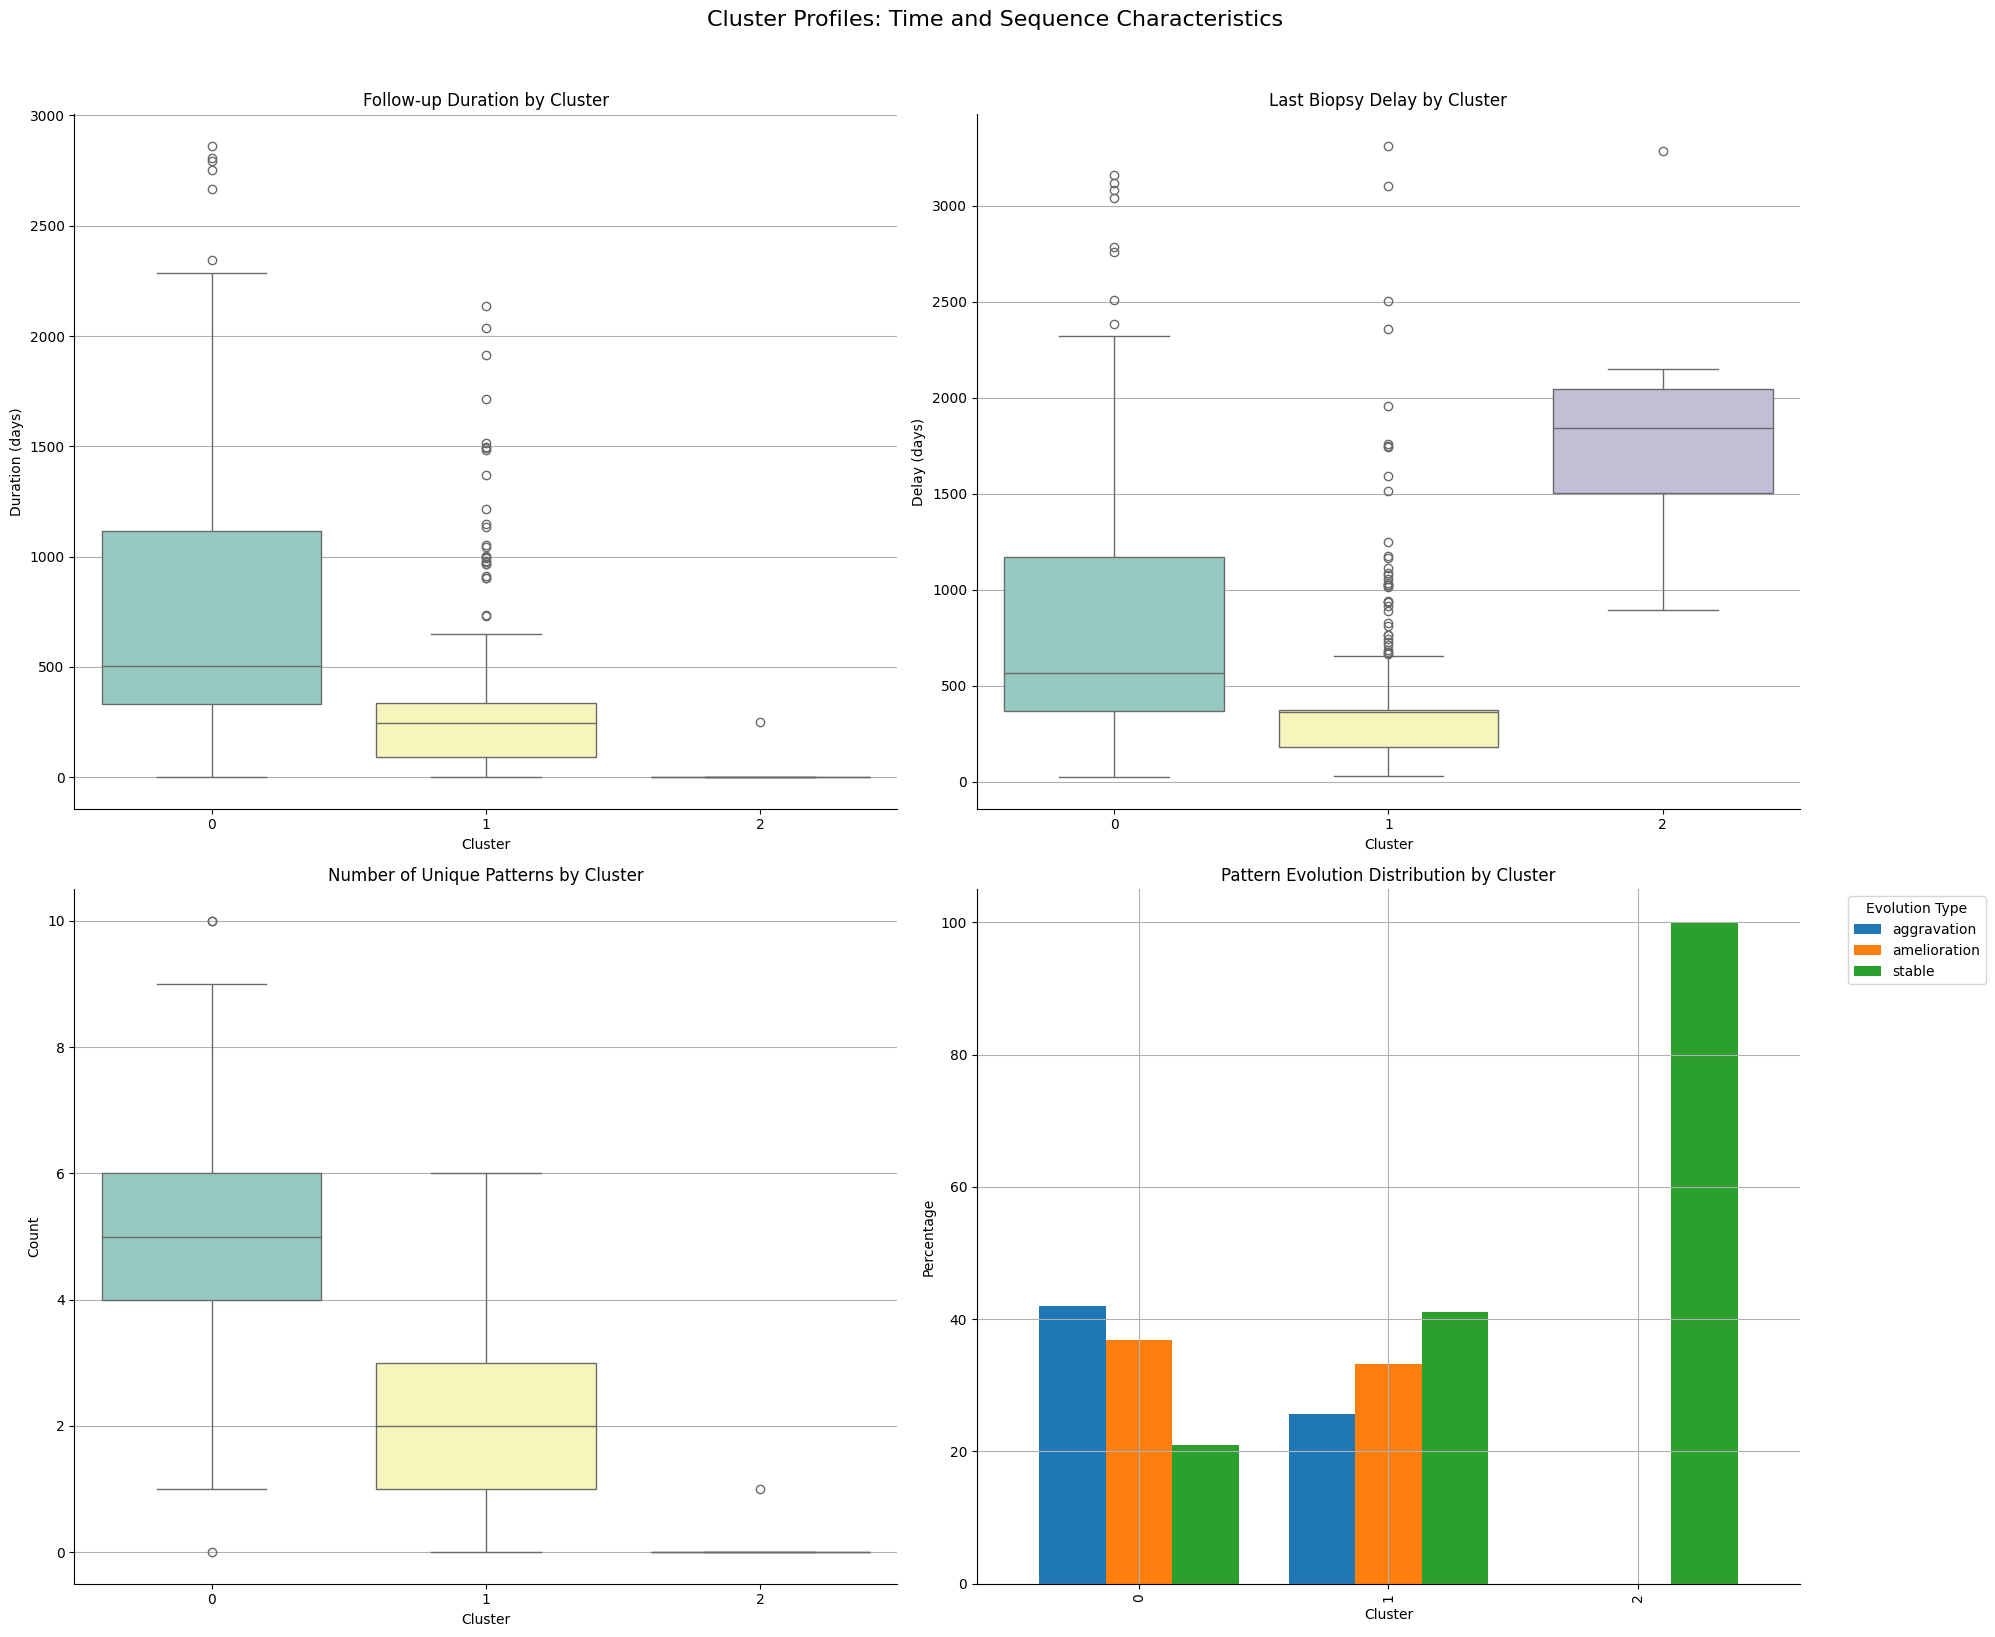

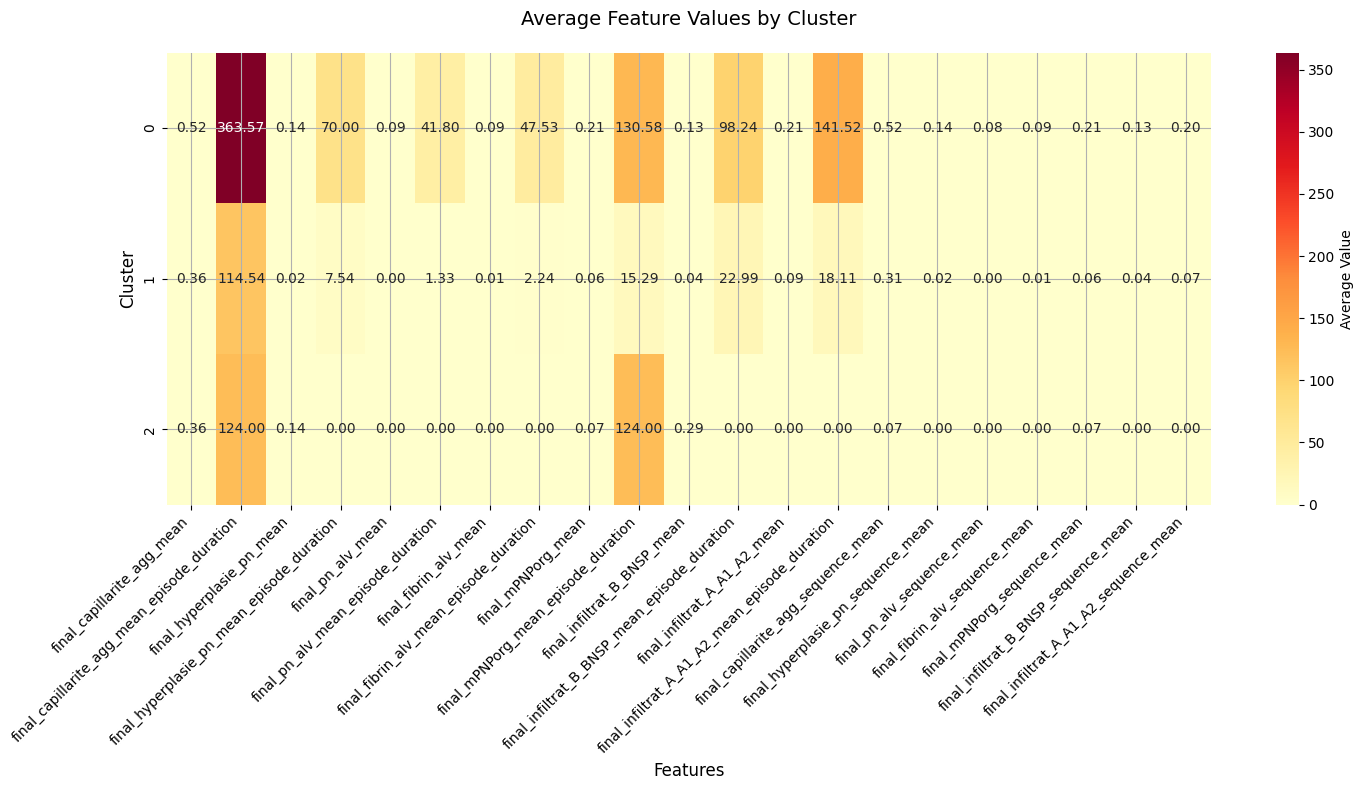

<Figure size 1200x600 with 0 Axes>

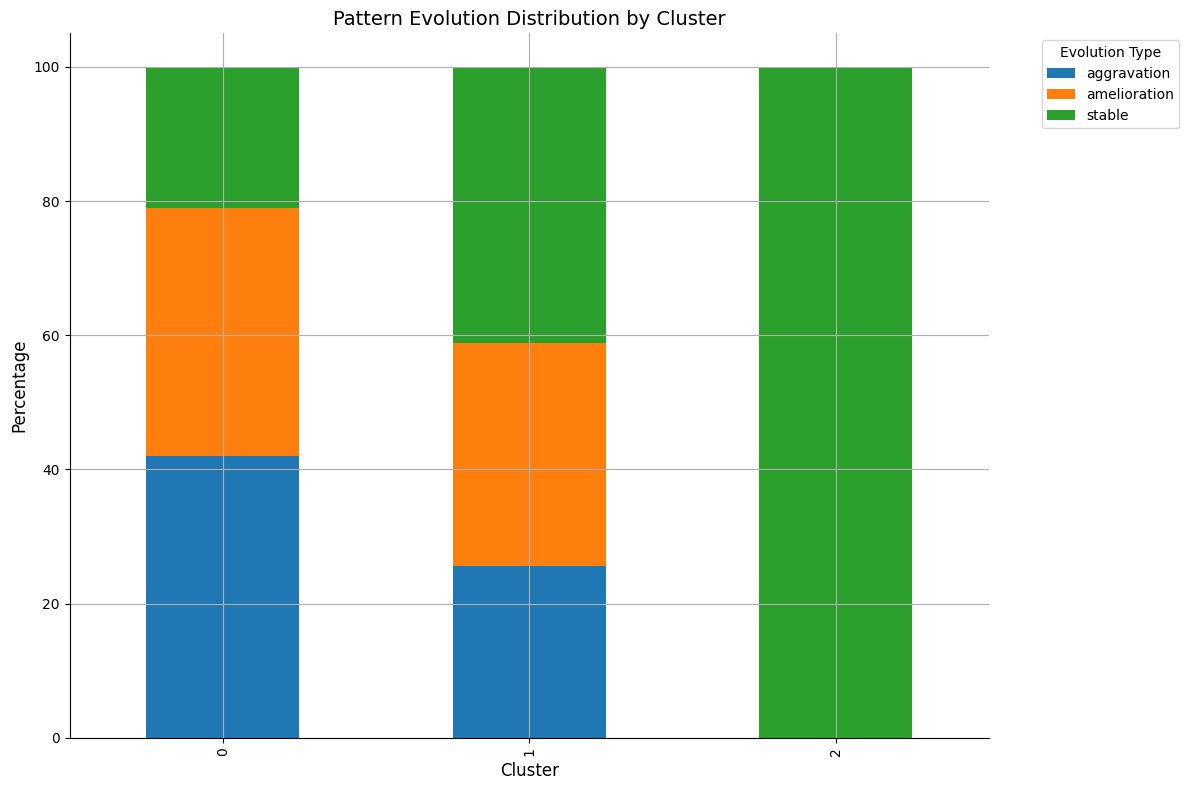

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_cluster_analysis(df, clusters):
    """Comprehensive visualization of cluster profiles"""
    
    # Set default style parameters
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['axes.grid'] = True
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    
    # 1. Duration and Sequence Analysis
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Cluster Profiles: Time and Sequence Characteristics', fontsize=16, y=1.02)
    
    # Duration metrics
    sns.boxplot(x=clusters, y=df['duree_suivi'], ax=axes[0,0], palette='Set3')
    axes[0,0].set_title('Follow-up Duration by Cluster', fontsize=12)
    axes[0,0].set_xlabel('Cluster', fontsize=10)
    axes[0,0].set_ylabel('Duration (days)', fontsize=10)
    
    sns.boxplot(x=clusters, y=df['delai_derniere_biopsie'], ax=axes[0,1], palette='Set3')
    axes[0,1].set_title('Last Biopsy Delay by Cluster', fontsize=12)
    axes[0,1].set_xlabel('Cluster', fontsize=10)
    axes[0,1].set_ylabel('Delay (days)', fontsize=10)
    
    # Sequence characteristics
    sns.boxplot(x=clusters, y=df['cluster_sequence_unique_patterns'], ax=axes[1,0], palette='Set3')
    axes[1,0].set_title('Number of Unique Patterns by Cluster', fontsize=12)
    axes[1,0].set_xlabel('Cluster', fontsize=10)
    axes[1,0].set_ylabel('Count', fontsize=10)
    
    # Pattern evolution distribution
    evolution_data = pd.crosstab(clusters, df['pattern_evolution'], normalize='index') * 100
    evolution_data.plot(kind='bar', ax=axes[1,1], width=0.8)
    axes[1,1].set_title('Pattern Evolution Distribution by Cluster', fontsize=12)
    axes[1,1].set_xlabel('Cluster', fontsize=10)
    axes[1,1].set_ylabel('Percentage', fontsize=10)
    axes[1,1].legend(title='Evolution Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    

    
    # 3. Mean Values Analysis
    mean_features = [col for col in df.columns if '_mean' in col and 'cluster' not in col]
    
    plt.figure(figsize=(15, 8))
    mean_values = df.groupby(clusters)[mean_features].mean()
    
    # Create heatmap of mean values
    sns.heatmap(mean_values, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
    plt.title('Average Feature Values by Cluster', fontsize=14, pad=20)
    plt.ylabel('Cluster', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 4. Radar Plot of Key Characteristics
    def make_spider(mean_values, title):
        categories = mean_values.index
        N = len(categories)
        
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]
        
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
        
        values = mean_values.values
        values = np.concatenate((values, [values[0]]))
        
        ax.plot(angles, values, linewidth=2, linestyle='solid')
        ax.fill(angles, values, alpha=0.25)
        
        plt.xticks(angles[:-1], categories, size=8)
        ax.set_title(title, size=14, y=1.05)
        
        # Add axis labels
        ax.set_rlabel_position(0)
        plt.tight_layout()
        
    # Select key features for radar plot
    key_features = [
        'final_capillarite_agg_mean',
        'final_hyperplasie_pn_mean',
        'final_pn_alv_mean',
        'final_fibrin_alv_mean',
        'final_mPNPorg_mean',
        'final_infiltrat_B_BNSP_mean',
        'final_infiltrat_A_A1_A2_mean',
     ]
    
    # 5. Pattern Evolution by Cluster
    plt.figure(figsize=(12, 6))
    evolution_percentages = pd.crosstab(clusters, df['pattern_evolution'], normalize='index') * 100
    evolution_percentages.plot(kind='bar', stacked=True)
    plt.title('Pattern Evolution Distribution by Cluster', fontsize=14)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.legend(title='Evolution Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    

# Add cluster labels to the dataframe
df['cluster'] = clusters

# Create visualizations
plot_cluster_analysis(df, clusters)

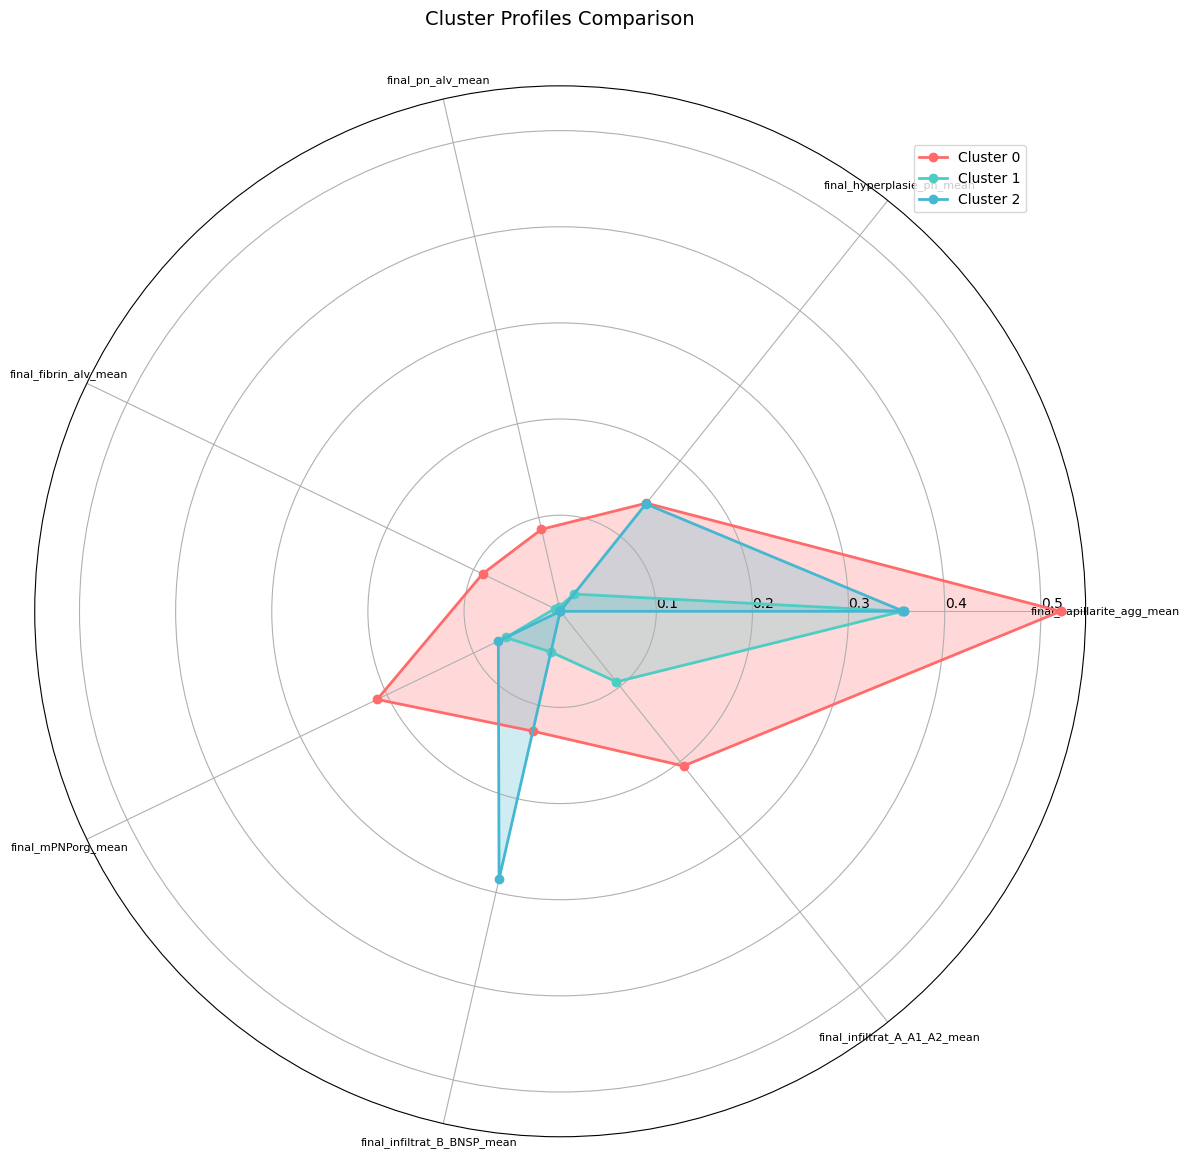

In [28]:
def plot_radar_comparison(df, clusters, key_features):
    """Create a single radar plot comparing all clusters"""
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
    
    # Number of variables
    categories = key_features
    N = len(categories)
    
    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # Colors for each cluster
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # You can modify these colors
    
    # Plot data
    for i in range(len(np.unique(clusters))):
        # Calculate means for this cluster
        values = df[df['cluster'] == i][key_features].mean().values
        values = np.concatenate((values, [values[0]]))  # Complete the loop
        
        # Plot
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {i}', color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    
    # Draw axis lines for each angle and label
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], categories, size=8, rotation=45)
    
    # Add legend
    plt.legend(bbox_to_anchor=(0.95, 0.95))
    
    # Add a title
    plt.title("Cluster Profiles Comparison", size=14, y=1.05)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    plt.show()

# Use the cleaned feature names for better readability
key_features = [
    'final_capillarite_agg_mean',
    'final_hyperplasie_pn_mean',
    'final_pn_alv_mean',
    'final_fibrin_alv_mean',
    'final_mPNPorg_mean',
    'final_infiltrat_B_BNSP_mean',
    'final_infiltrat_A_A1_A2_mean'
]

# Create the radar plot
plot_radar_comparison(df, clusters, key_features)

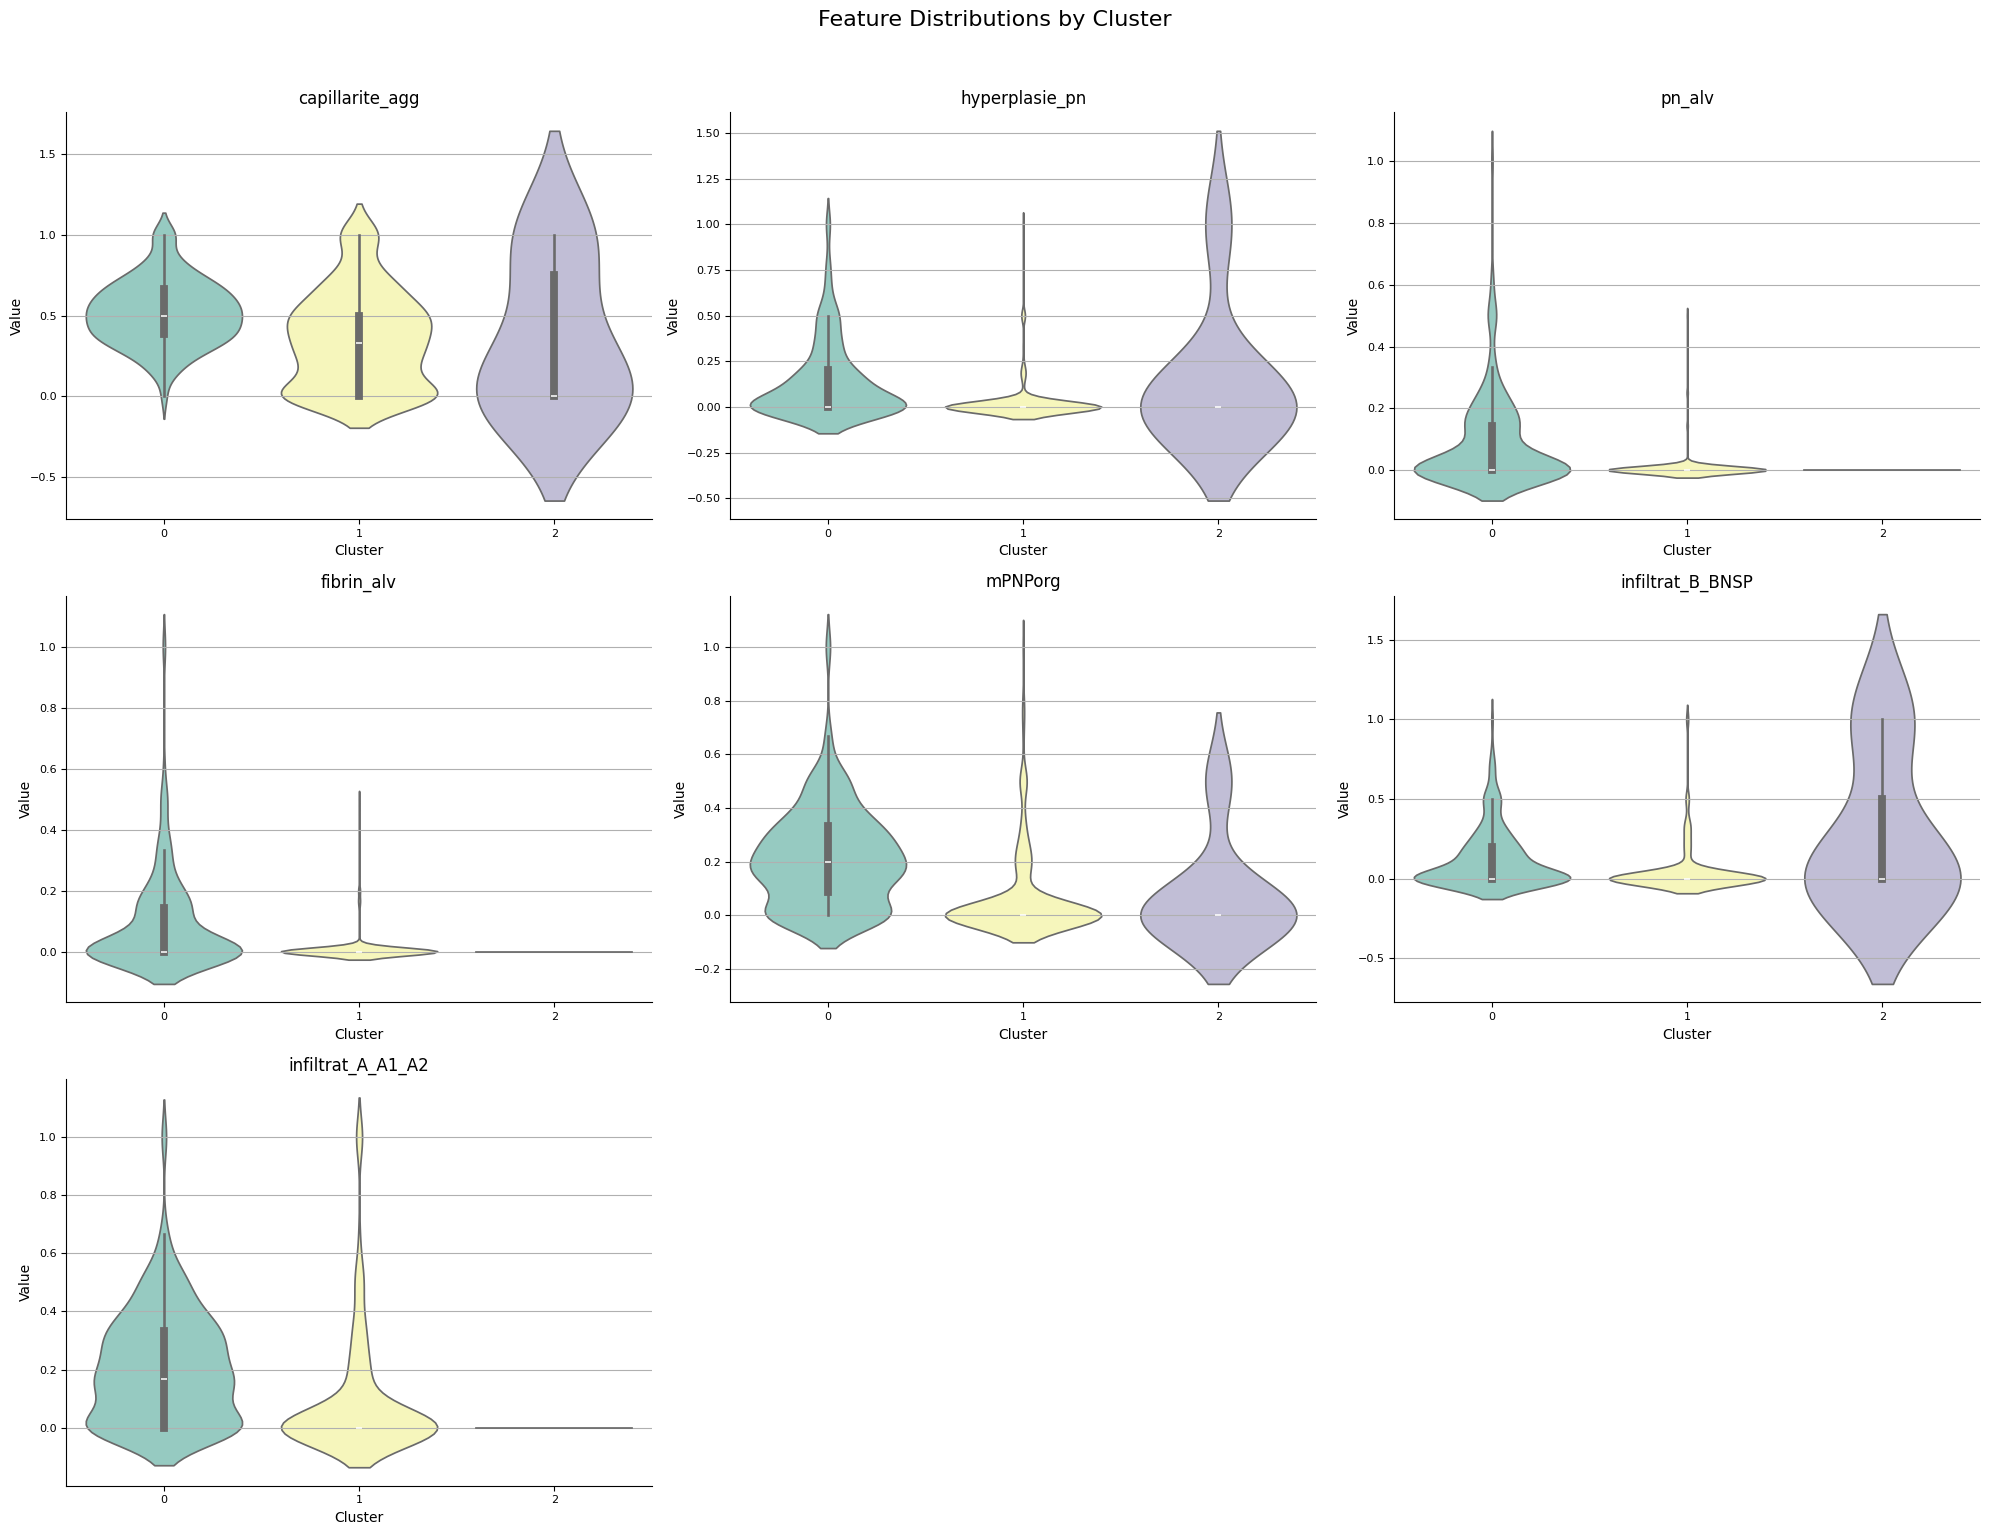

In [29]:
def plot_feature_distributions(df, clusters, key_features):
    """Create violin plots for all features in a single figure"""
    
    # Calculate number of rows and columns for subplots
    n_features = len(key_features)
    n_cols = 3  # You can adjust this
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    fig.suptitle('Feature Distributions by Cluster', fontsize=16, y=1.02)
    
    # Flatten axes array for easier iteration
    axes = axes.flatten()
    
    # Create violin plots
    for i, feature in enumerate(key_features):
        sns.violinplot(x=clusters, y=df[feature], ax=axes[i], palette='Set3')
        
        # Customize each subplot
        axes[i].set_title(feature.replace('final_', '').replace('_mean', ''), fontsize=12)
        axes[i].set_xlabel('Cluster', fontsize=10)
        axes[i].set_ylabel('Value', fontsize=10)
        axes[i].tick_params(axis='both', which='major', labelsize=8)
        
    # Remove empty subplots if any
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Define key features
key_features = [
    'final_capillarite_agg_mean',
    'final_hyperplasie_pn_mean',
    'final_pn_alv_mean',
    'final_fibrin_alv_mean',
    'final_mPNPorg_mean',
    'final_infiltrat_B_BNSP_mean',
    'final_infiltrat_A_A1_A2_mean'
]

# Create the plots
plot_feature_distributions(df, clusters, key_features)

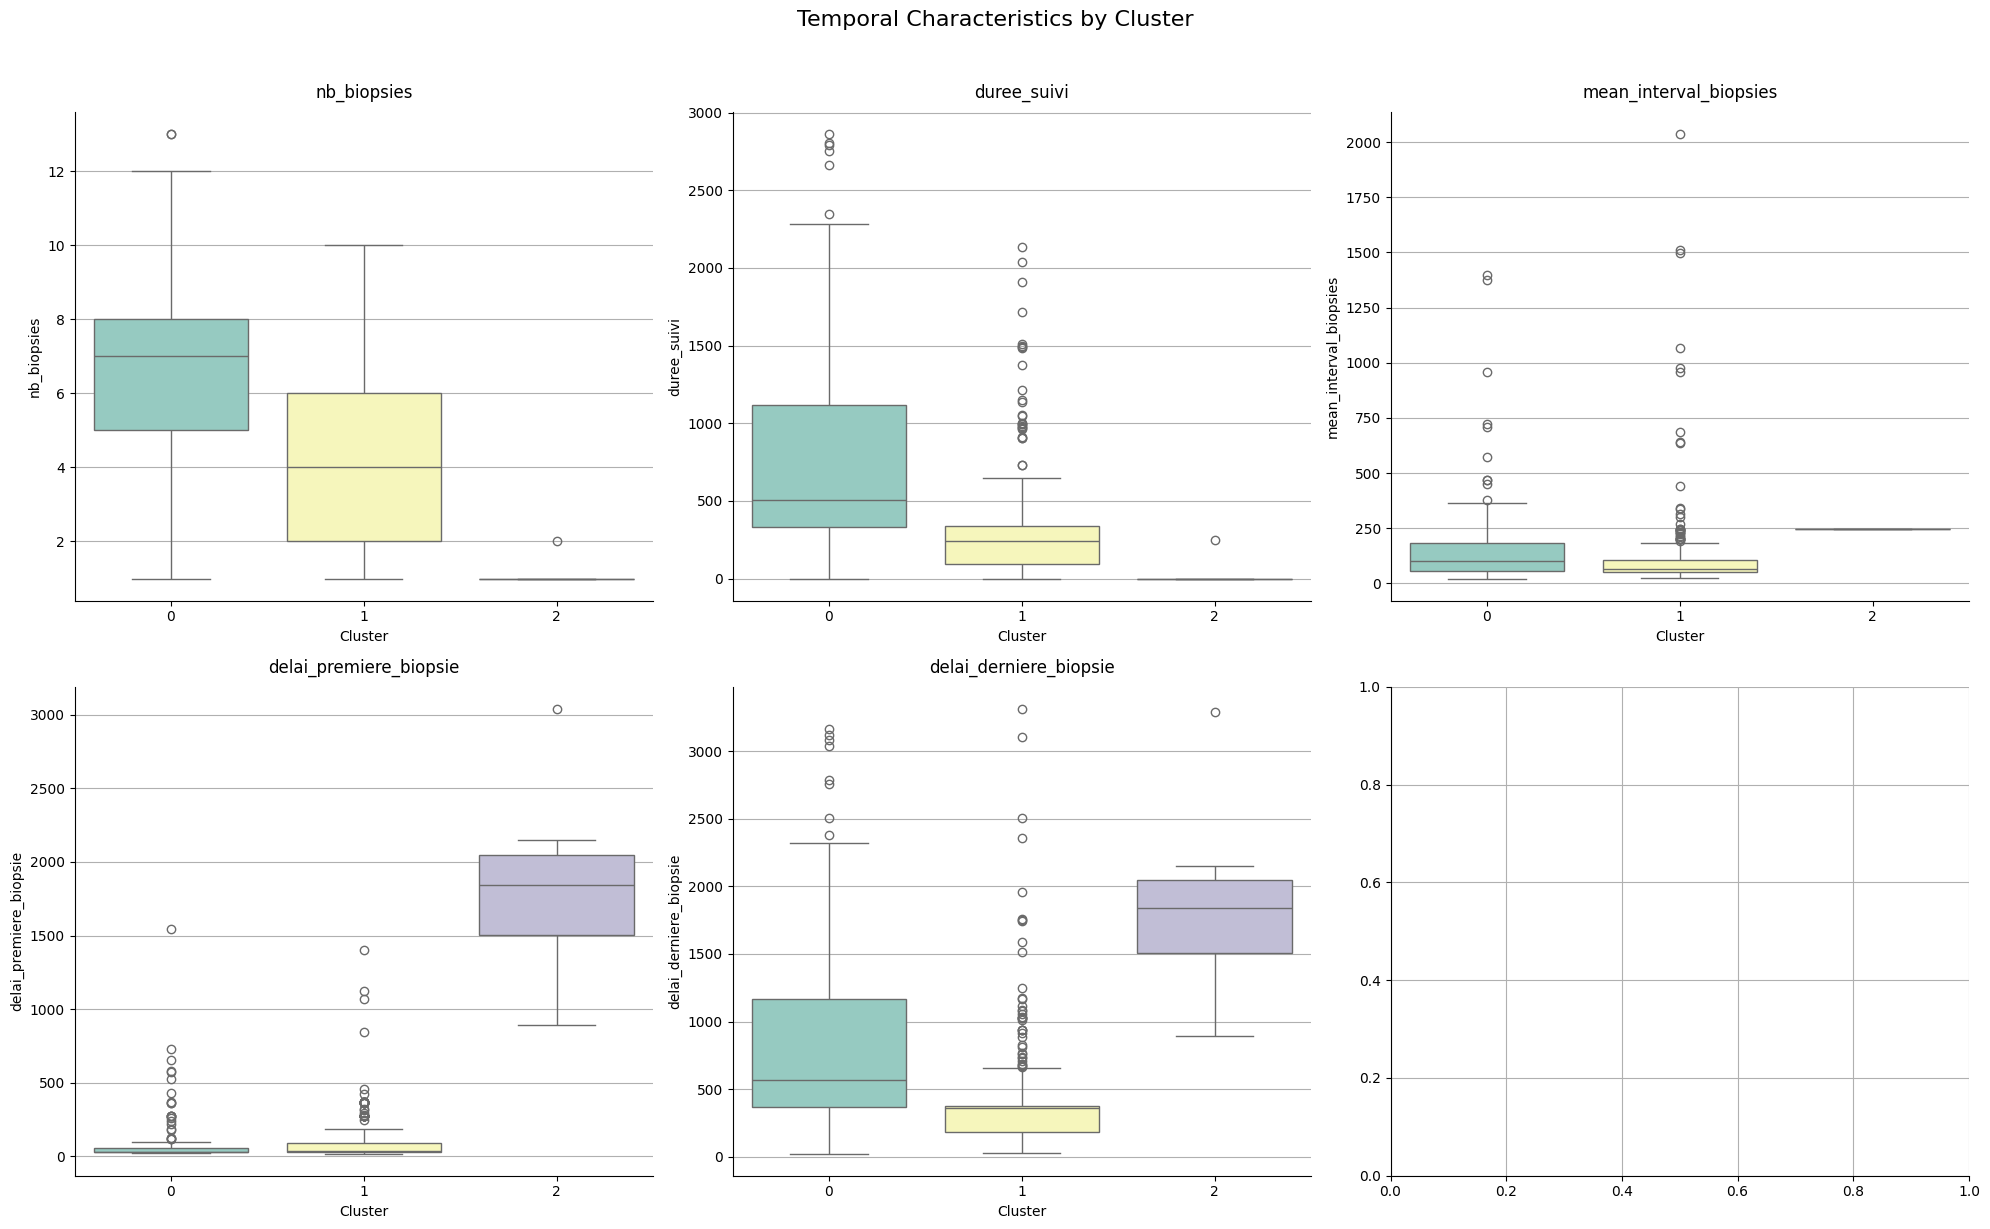

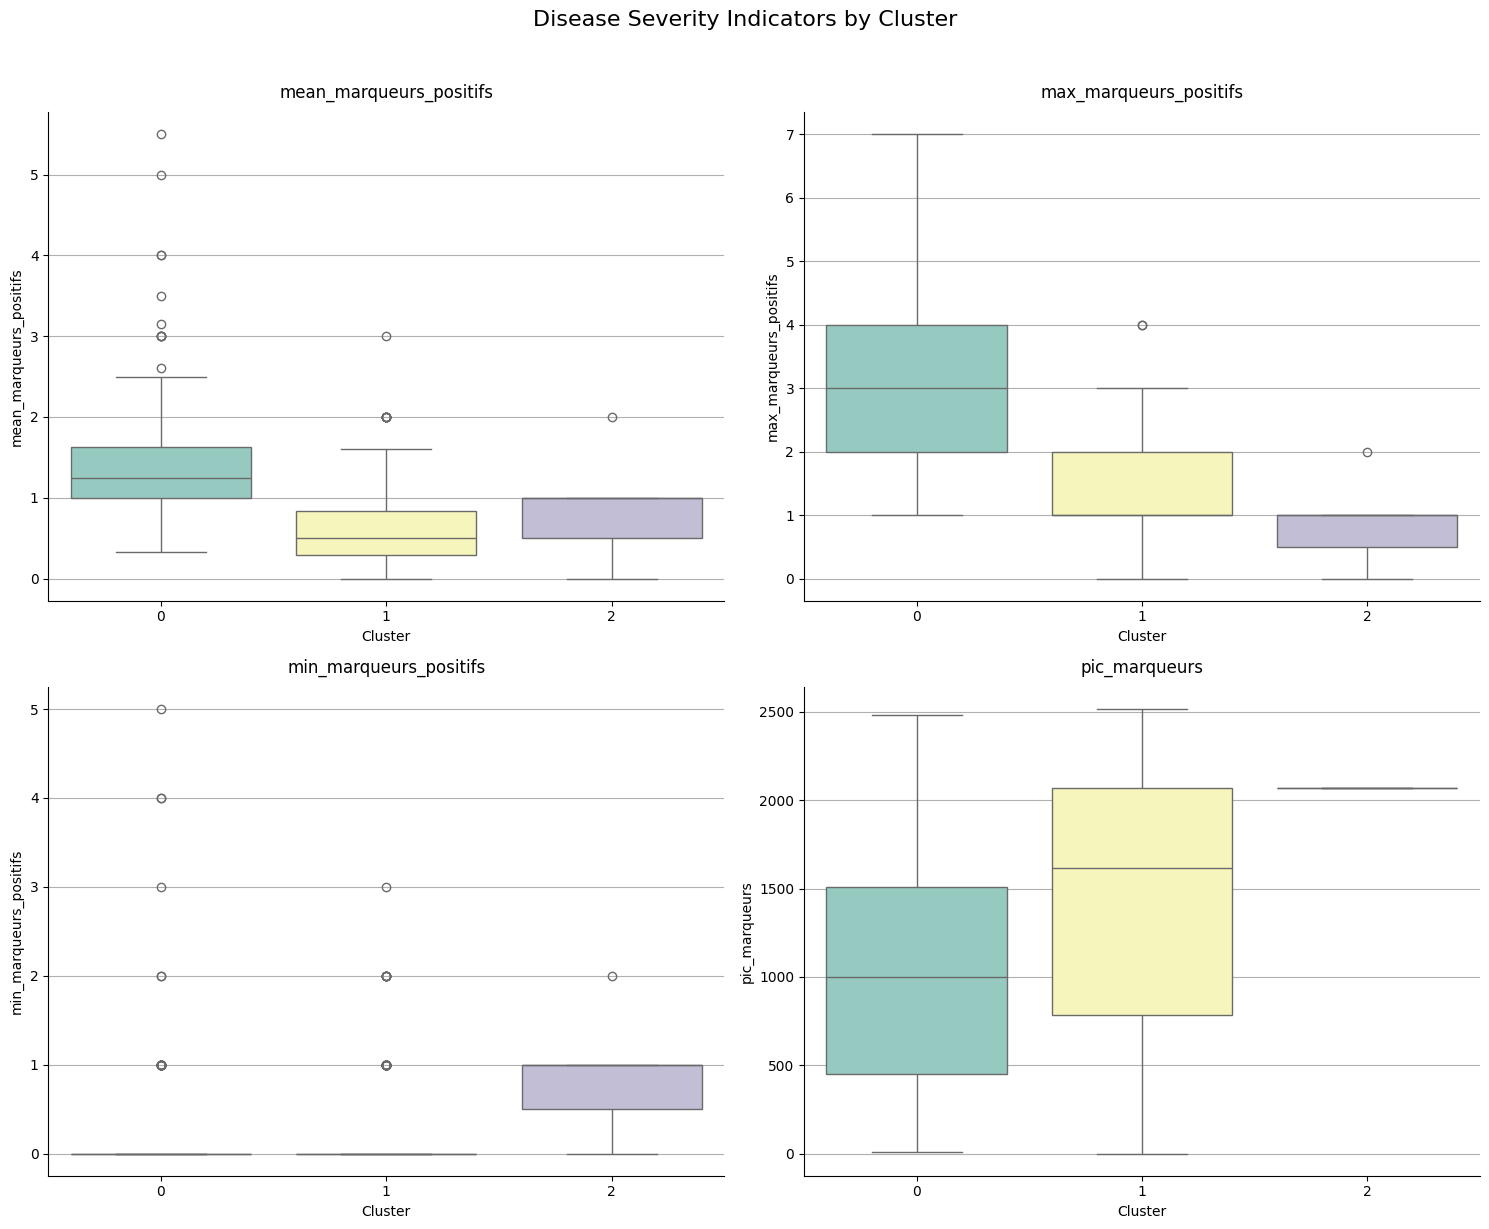

<Figure size 1000x600 with 0 Axes>

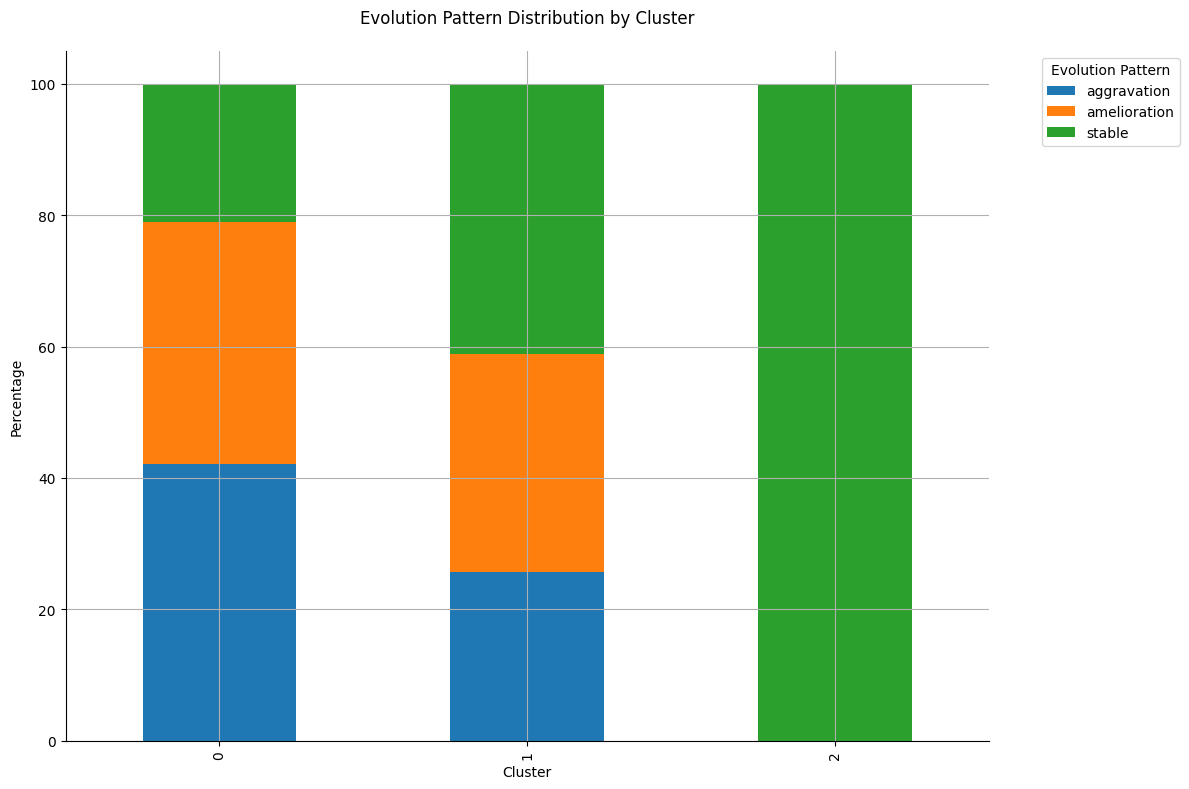

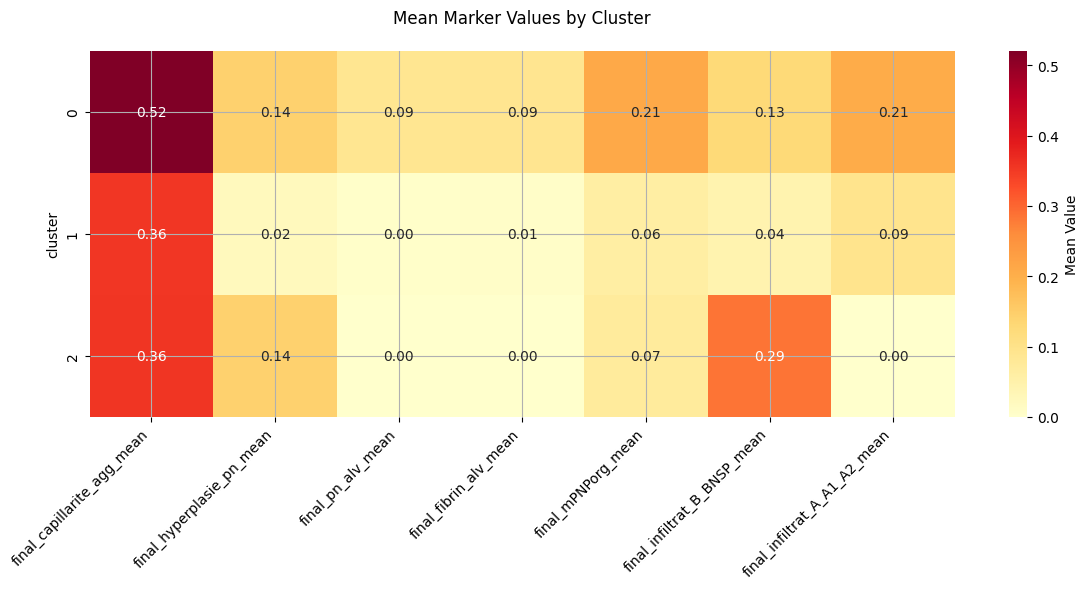

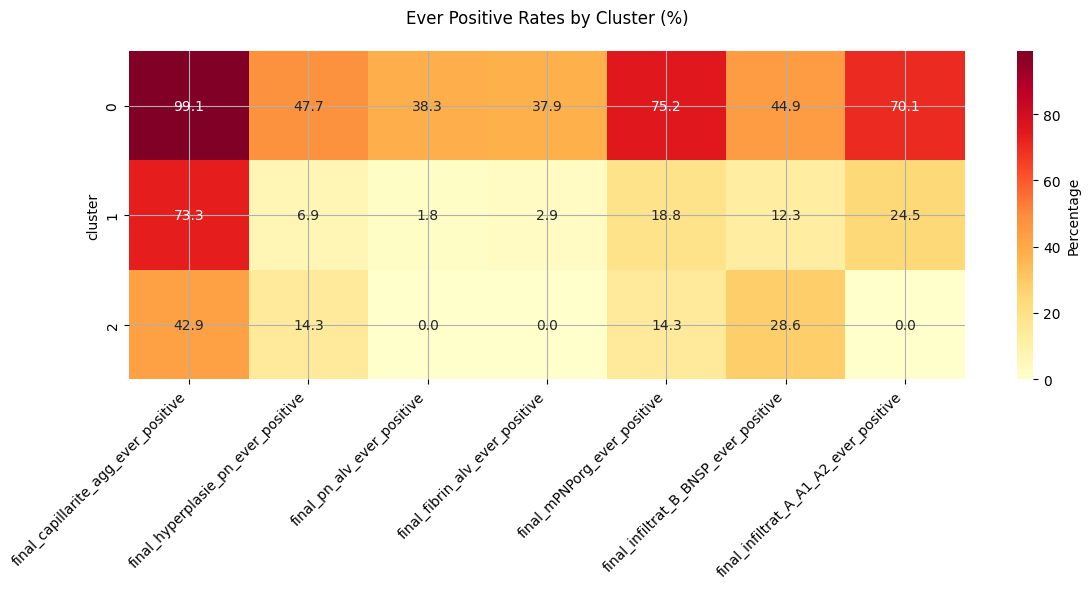


=== Temporal Characteristics ===
        nb_biopsies        duree_suivi          mean_interval_biopsies  \
               mean    std        mean      std                   mean   
cluster                                                                  
0             6.425  2.405     766.551  667.573                152.727   
1             4.101  2.008     308.639  350.216                124.425   
2             1.143  0.378      35.429   93.735                248.000   

                 delai_premiere_biopsie          delai_derniere_biopsie  \
             std                   mean      std                   mean   
cluster                                                                   
0        176.514                 76.196  146.906                842.748   
1        219.567                 98.599  157.595                407.238   
2            NaN               1839.857  667.489               1875.286   

                  
             std  
cluster           
0        699.

In [30]:
def analyze_cluster_profiles(df):
    """Analyze and visualize key characteristics of each cluster"""
    
    # 1. Define key feature groups
    temporal_features = [
        'nb_biopsies', 'duree_suivi', 'mean_interval_biopsies',
        'delai_premiere_biopsie', 'delai_derniere_biopsie'
    ]
    
    severity_features = [
        'mean_marqueurs_positifs', 'max_marqueurs_positifs',
        'min_marqueurs_positifs', 'pic_marqueurs'
    ]
    
    stability_features = [
        'stabilite_globale', 'progression_rate', 'nb_changements_cluster',
        'nb_clusters_uniques', 'prop_cluster_dominant'
    ]
    
    markers_mean = [
        'final_capillarite_agg_mean', 'final_hyperplasie_pn_mean',
        'final_pn_alv_mean', 'final_fibrin_alv_mean', 'final_mPNPorg_mean',
        'final_infiltrat_B_BNSP_mean', 'final_infiltrat_A_A1_A2_mean'
    ]
    
    markers_ever_positive = [col for col in df.columns if 'ever_positive' in col]
    markers_always_positive = [col for col in df.columns if 'always_positive' in col]
    cooccurrence_features = [col for col in df.columns if 'cooc_' in col]
    
    def create_summary_table(feature_group, group_name):
        """Create summary statistics for a feature group"""
        summary = df.groupby('cluster')[feature_group].agg(['mean', 'std'])
        print(f"\n=== {group_name} ===")
        print(summary.round(3))
        return summary
    
    # Set basic matplotlib parameters
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['axes.grid'] = True
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    
    # 2.1 Temporal characteristics
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Temporal Characteristics by Cluster', fontsize=16, y=1.02)
    axes = axes.ravel()
    
    for i, feature in enumerate(temporal_features):
        sns.boxplot(x='cluster', y=feature, data=df, ax=axes[i], palette='Set3')
        axes[i].set_title(feature, pad=10)
        axes[i].set_xlabel('Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # 2.2 Disease Severity
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Disease Severity Indicators by Cluster', fontsize=16, y=1.02)
    axes = axes.ravel()
    
    for i, feature in enumerate(severity_features):
        sns.boxplot(x='cluster', y=feature, data=df, ax=axes[i], palette='Set3')
        axes[i].set_title(feature, pad=10)
        axes[i].set_xlabel('Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # 2.3 Evolution Pattern Distribution
    plt.figure(figsize=(10, 6))
    evolution_dist = pd.crosstab(df['cluster'], df['pattern_evolution'], normalize='index') * 100
    evolution_dist.plot(kind='bar', stacked=True)
    plt.title('Evolution Pattern Distribution by Cluster', pad=20)
    plt.xlabel('Cluster')
    plt.ylabel('Percentage')
    plt.legend(title='Evolution Pattern', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()
    
    # 2.4 Markers Profile
    plt.figure(figsize=(12, 6))
    markers_summary = df.groupby('cluster')[markers_mean].mean()
    sns.heatmap(markers_summary, annot=True, fmt='.2f', cmap='YlOrRd',
                cbar_kws={'label': 'Mean Value'})
    plt.title('Mean Marker Values by Cluster', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 2.5 Ever Positive Rates
    ever_positive_rates = df.groupby('cluster')[markers_ever_positive].mean() * 100
    plt.figure(figsize=(12, 6))
    sns.heatmap(ever_positive_rates, annot=True, fmt='.1f', cmap='YlOrRd',
                cbar_kws={'label': 'Percentage'})
    plt.title('Ever Positive Rates by Cluster (%)', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 3. Statistical Summaries
    summaries = {
        'Temporal Characteristics': create_summary_table(temporal_features, 'Temporal Characteristics'),
        'Disease Severity': create_summary_table(severity_features, 'Disease Severity Indicators'),
        'Stability Metrics': create_summary_table(stability_features, 'Stability Metrics'),
        'Marker Means': create_summary_table(markers_mean, 'Mean Marker Values'),
        'Cooccurrence': create_summary_table(cooccurrence_features, 'Marker Cooccurrence')
    }
    
    # 4. Detailed Cluster Profiles
    print("\n=== Detailed Cluster Profiles ===")
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        print(f"\nCluster {cluster} (N={len(cluster_data)}, {len(cluster_data)/len(df)*100:.1f}%):")
        
        # Evolution pattern
        evolution = cluster_data['pattern_evolution'].value_counts(normalize=True)
        print(f"\nEvolution Patterns:")
        for pattern, prop in evolution.items():
            print(f"- {pattern}: {prop*100:.1f}%")
        
        # Key metrics
        print(f"\nKey Metrics:")
        print(f"- Average follow-up duration: {cluster_data['duree_suivi'].mean():.1f} days")
        print(f"- Average number of biopsies: {cluster_data['nb_biopsies'].mean():.1f}")
        print(f"- Stability score: {cluster_data['stabilite_globale'].mean():.3f}")
        print(f"- Progression rate: {cluster_data['progression_rate'].mean():.3f}")
        
        # Most common markers
        print("\nMost Frequent Markers (Ever Positive):")
        ever_positive = cluster_data[markers_ever_positive].mean().sort_values(ascending=False)
        for marker, rate in ever_positive.head(3).items():
            print(f"- {marker}: {rate*100:.1f}%")
        
        # Marker means
        print("\nMarker Means:")
        marker_means = cluster_data[markers_mean].mean().sort_values(ascending=False)
        for marker, mean_val in marker_means.head(3).items():
            print(f"- {marker}: {mean_val:.3f}")
    
    return summaries

# Run the analysis
summaries = analyze_cluster_profiles(df)

<Figure size 1500x600 with 0 Axes>

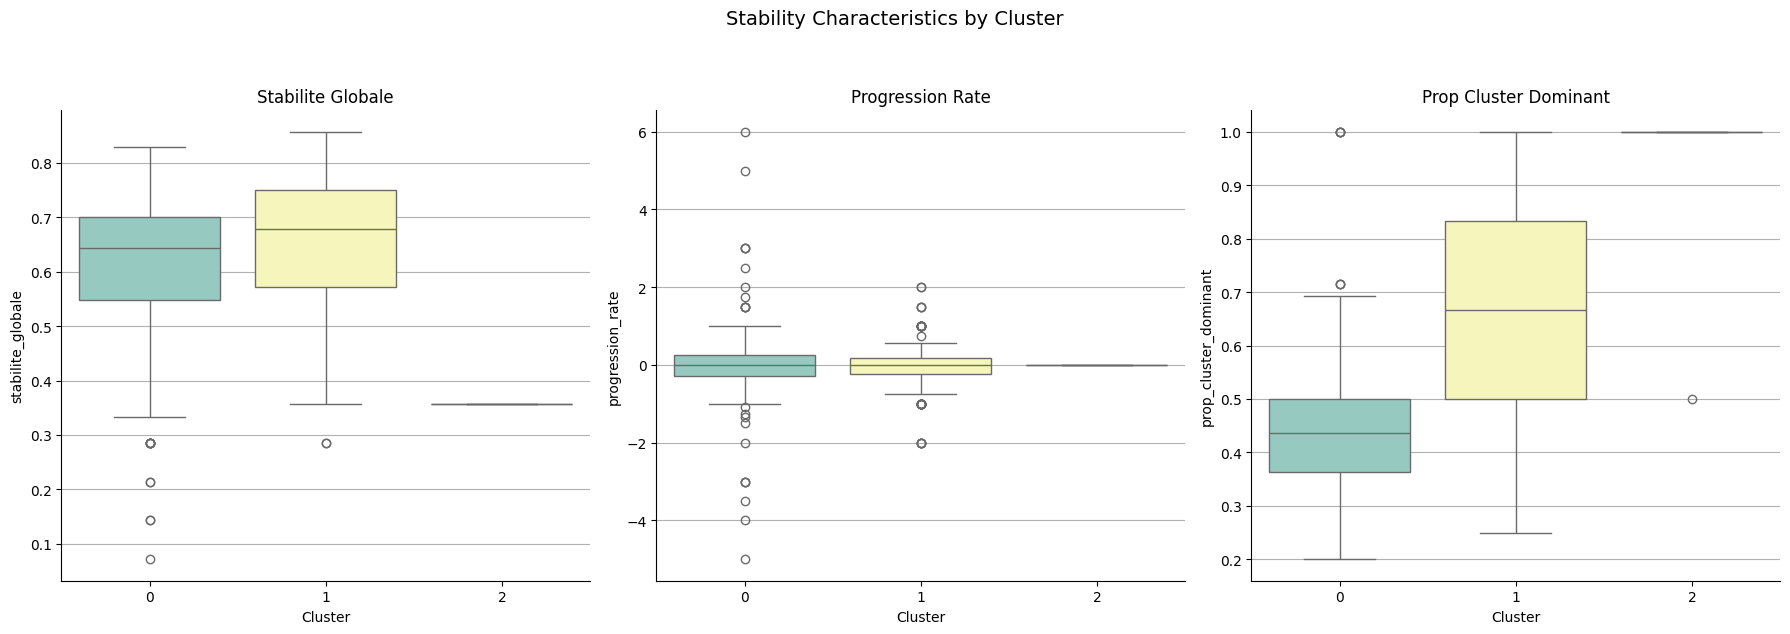

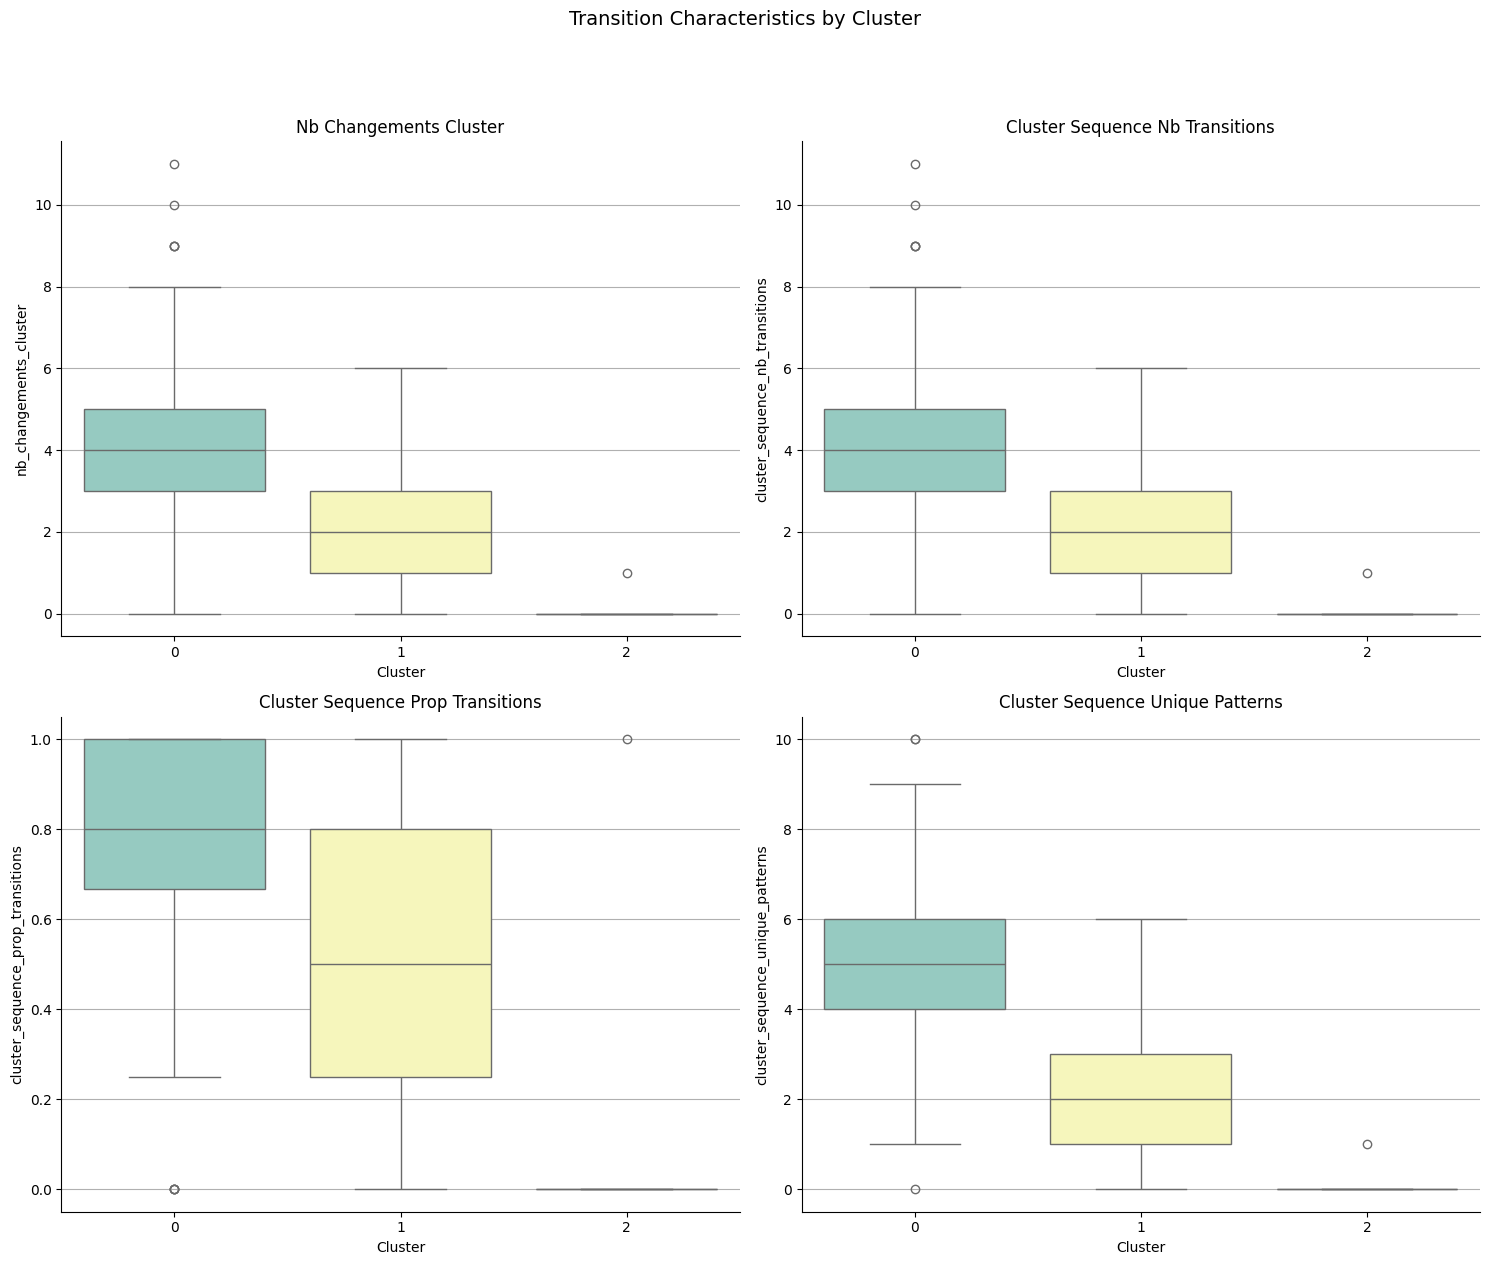

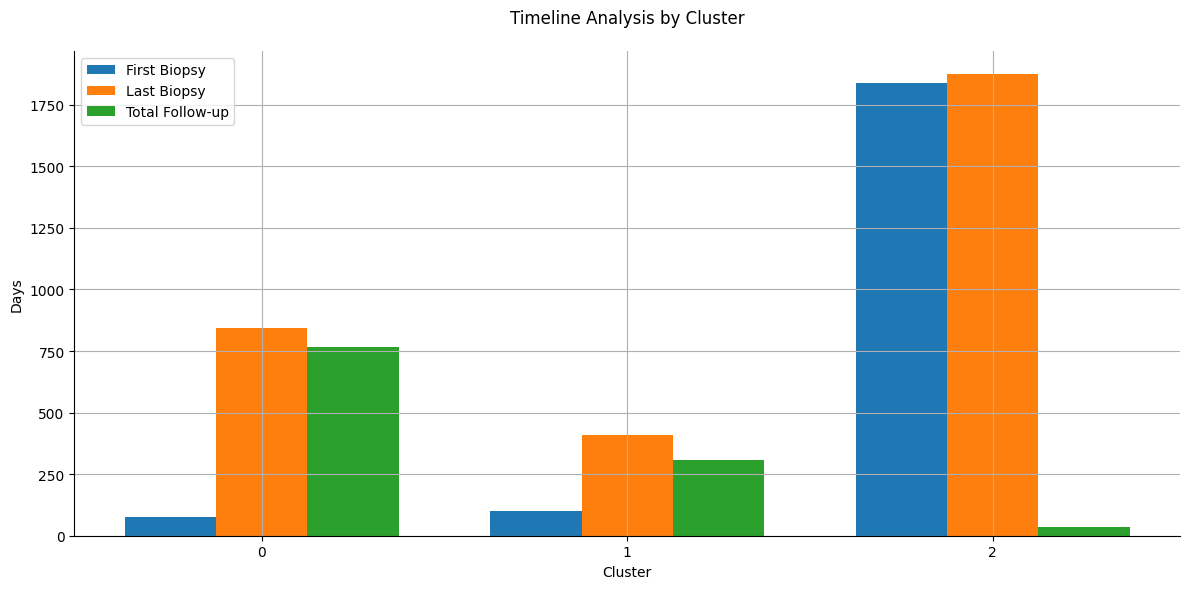

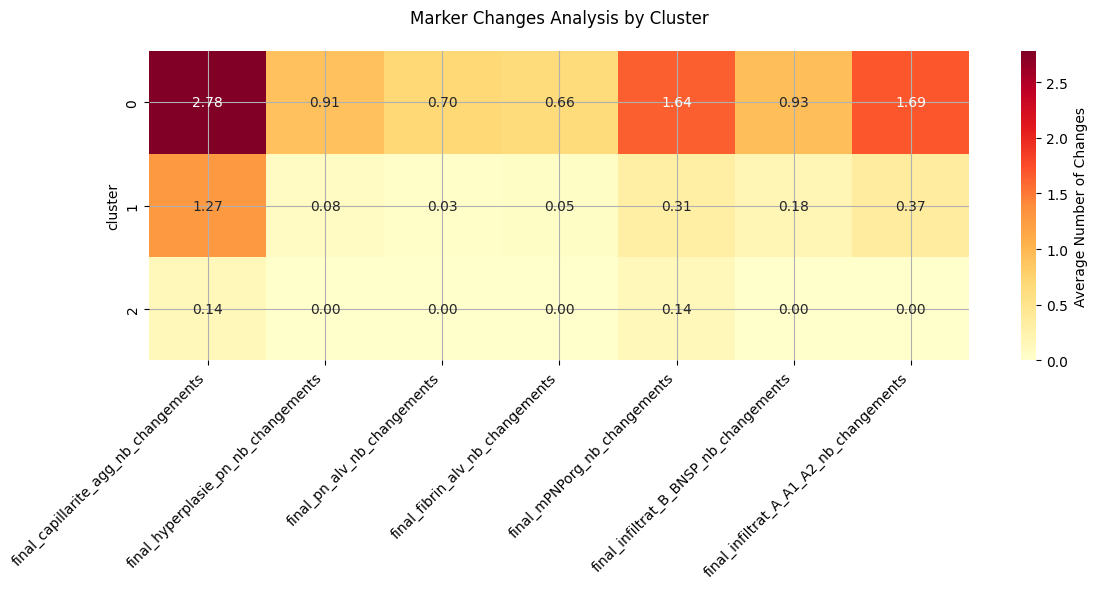

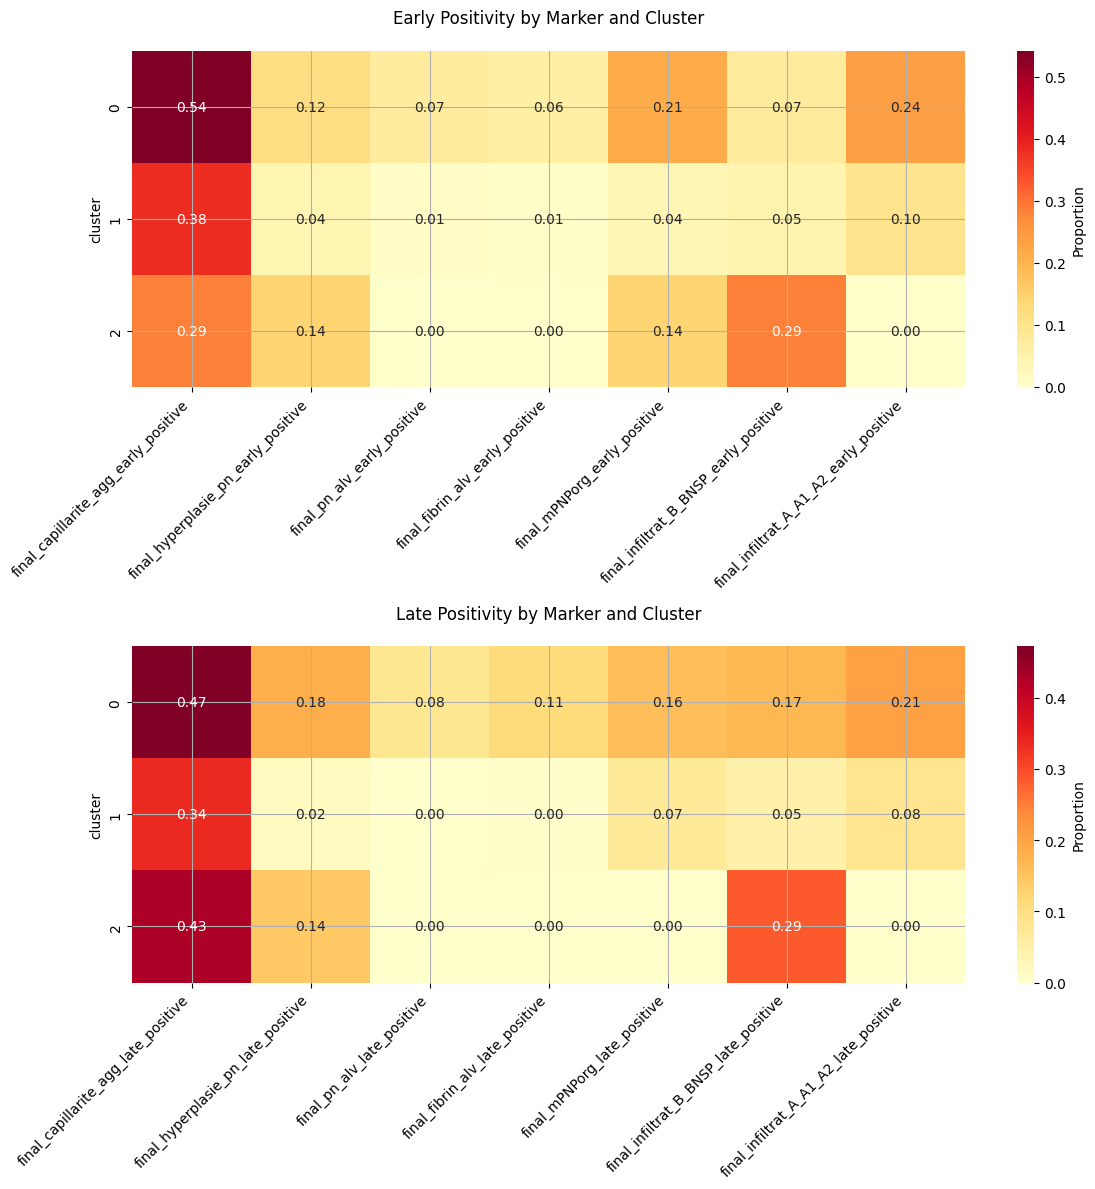

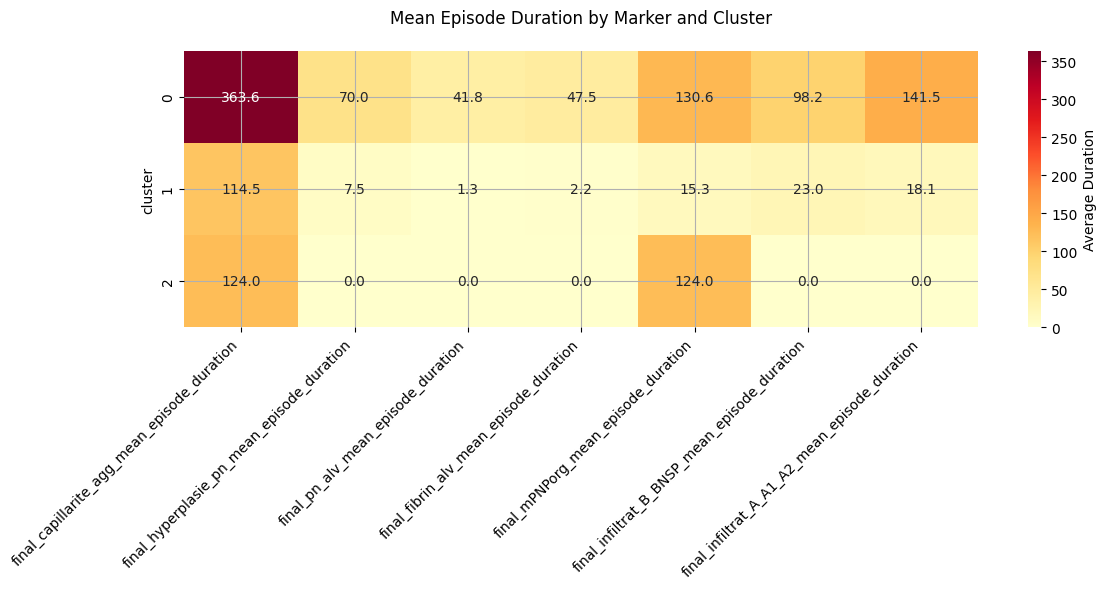

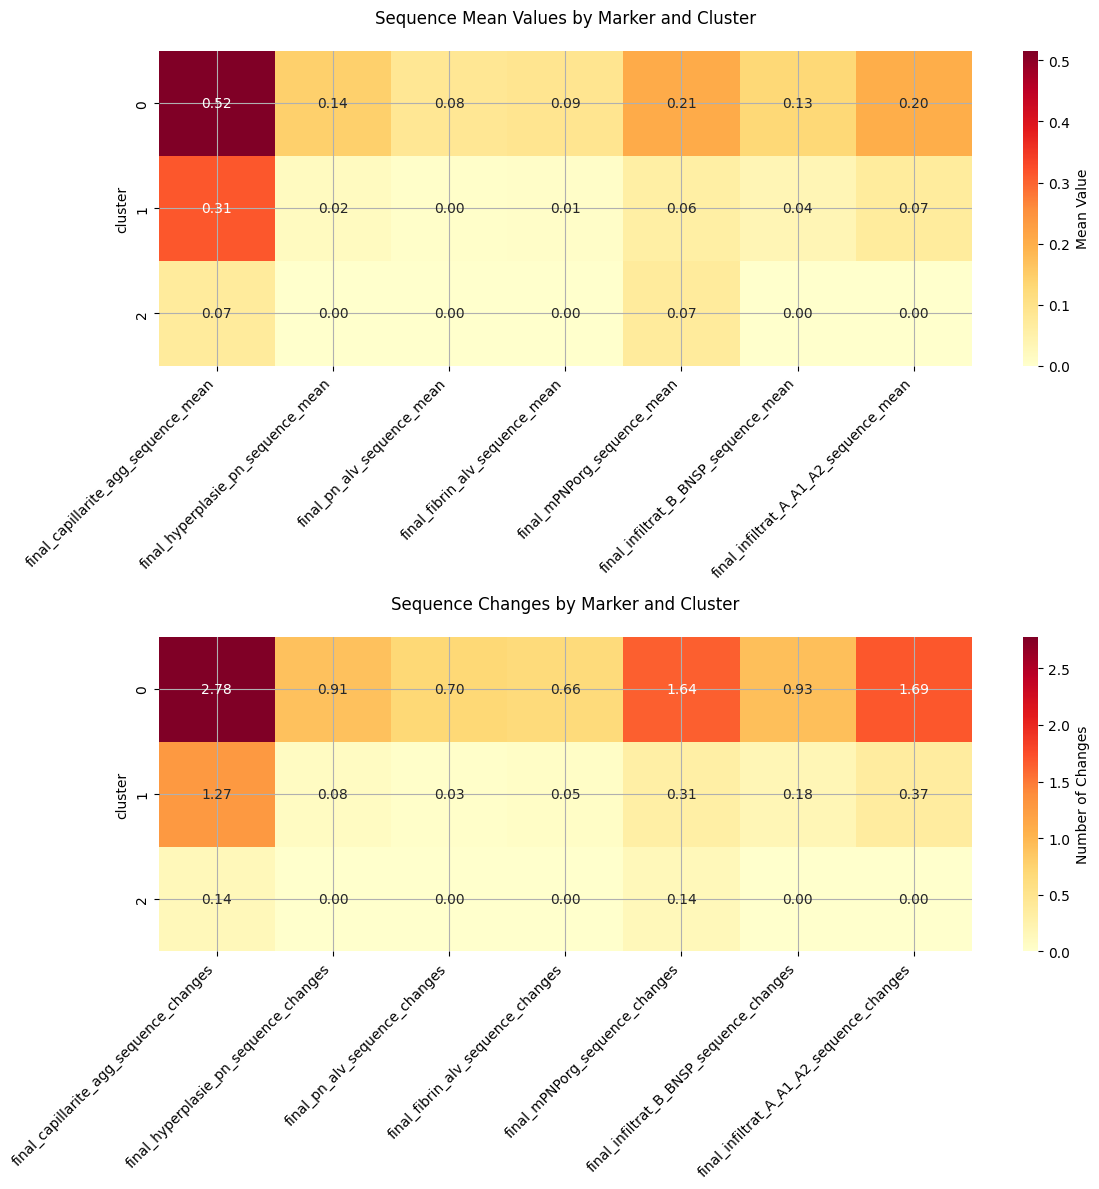

In [31]:
def create_additional_visualizations(df):
    """Create additional visualizations for cluster analysis"""
    
    # 1. Stability and Change Analysis
    plt.figure(figsize=(15, 6))
    stability_features = ['stabilite_globale', 'progression_rate', 'prop_cluster_dominant']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Stability Characteristics by Cluster', fontsize=14, y=1.05)
    
    for i, feature in enumerate(stability_features):
        sns.boxplot(x='cluster', y=feature, data=df, ax=axes[i], palette='Set3')
        axes[i].set_title(feature.replace('_', ' ').title())
        axes[i].set_xlabel('Cluster')
    
    plt.tight_layout()
    plt.show()

    # 2. Transition Analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Transition Characteristics by Cluster', fontsize=14, y=1.05)
    
    transition_features = [
        'nb_changements_cluster',
        'cluster_sequence_nb_transitions',
        'cluster_sequence_prop_transitions',
        'cluster_sequence_unique_patterns'
    ]
    
    for i, feature in enumerate(transition_features):
        sns.boxplot(x='cluster', y=feature, data=df, ax=axes[i//2, i%2], palette='Set3')
        axes[i//2, i%2].set_title(feature.replace('_', ' ').title())
        axes[i//2, i%2].set_xlabel('Cluster')
    
    plt.tight_layout()
    plt.show()

    # 3. Timeline Analysis
    time_features = ['delai_premiere_biopsie', 'delai_derniere_biopsie', 'duree_suivi']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    cluster_means = df.groupby('cluster')[time_features].mean()
    
    x = np.arange(len(cluster_means))
    width = 0.25
    
    ax.bar(x - width, cluster_means['delai_premiere_biopsie'], width, label='First Biopsy')
    ax.bar(x, cluster_means['delai_derniere_biopsie'], width, label='Last Biopsy')
    ax.bar(x + width, cluster_means['duree_suivi'], width, label='Total Follow-up')
    
    ax.set_title('Timeline Analysis by Cluster', pad=20)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Days')
    ax.set_xticks(x)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # 4. Marker Changes Analysis
    change_features = [col for col in df.columns if 'nb_changements' in col and 'cluster' not in col]
    
    plt.figure(figsize=(12, 6))
    changes_summary = df.groupby('cluster')[change_features].mean()
    sns.heatmap(changes_summary, annot=True, fmt='.2f', cmap='YlOrRd',
                cbar_kws={'label': 'Average Number of Changes'})
    plt.title('Marker Changes Analysis by Cluster', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 5. Early vs Late Positivity Analysis
    early_features = [col for col in df.columns if 'early_positive' in col]
    late_features = [col for col in df.columns if 'late_positive' in col]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Early positivity
    early_summary = df.groupby('cluster')[early_features].mean()
    sns.heatmap(early_summary, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax1,
                cbar_kws={'label': 'Proportion'})
    ax1.set_title('Early Positivity by Marker and Cluster', pad=20)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Late positivity
    late_summary = df.groupby('cluster')[late_features].mean()
    sns.heatmap(late_summary, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax2,
                cbar_kws={'label': 'Proportion'})
    ax2.set_title('Late Positivity by Marker and Cluster', pad=20)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

    # 6. Episode Duration Analysis
    duration_features = [col for col in df.columns if 'mean_episode_duration' in col]
    
    plt.figure(figsize=(12, 6))
    duration_summary = df.groupby('cluster')[duration_features].mean()
    sns.heatmap(duration_summary, annot=True, fmt='.1f', cmap='YlOrRd',
                cbar_kws={'label': 'Average Duration'})
    plt.title('Mean Episode Duration by Marker and Cluster', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 7. Sequence Characteristics Analysis
    sequence_features = [
        'final_capillarite_agg_sequence_mean',
        'final_hyperplasie_pn_sequence_mean',
        'final_pn_alv_sequence_mean',
        'final_fibrin_alv_sequence_mean',
        'final_mPNPorg_sequence_mean',
        'final_infiltrat_B_BNSP_sequence_mean',
        'final_infiltrat_A_A1_A2_sequence_mean'
    ]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Sequence means
    sequence_means = df.groupby('cluster')[sequence_features].mean()
    sns.heatmap(sequence_means, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax1,
                cbar_kws={'label': 'Mean Value'})
    ax1.set_title('Sequence Mean Values by Marker and Cluster', pad=20)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Sequence changes
    change_features = [col.replace('mean', 'changes') for col in sequence_features]
    change_means = df.groupby('cluster')[change_features].mean()
    sns.heatmap(change_means, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax2,
                cbar_kws={'label': 'Number of Changes'})
    ax2.set_title('Sequence Changes by Marker and Cluster', pad=20)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Run the additional visualizations
create_additional_visualizations(df)